In [1]:
# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt


# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from mne_bids import BIDSPath
from mne import EpochsArray
from mne.viz import plot_compare_evokeds
from copy import deepcopy
import mne
from statsmodels.formula.api import mixedlm


from scipy.stats import ttest_ind


# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


# import summary_df from csv file
summary_df = pd.read_csv("global_mean_stddev_zscore.csv")

stats_df = pd.read_csv("individual_mean_stddev_zscore_negcorr.csv")



# Preprocessing

In [2]:

def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()

    
    
    # Remove break annotations
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    
    
    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    
    # get the total number of short channels
    short_chs = get_short_channels(raw_od)
    tot_number_of_short_channels = len(short_chs.ch_names)
    

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.7, h_freq=1.45)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.8))
    
    if len(bad_channels) > 55:
        print(f"❌ Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None, None, None, None, None
    
    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels
 
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)

    
     # Get long channels
    long_chs = get_long_channels(raw_od)
    bad_long_chs = long_chs.info["bads"]
    
    len_bad_short_chs = len(bad_channels) - len(bad_long_chs)
    num_good_short_channels = tot_number_of_short_channels - len_bad_short_chs

    # Determine if there are short channels
    if num_good_short_channels < 4:
        print("❌ No short channels found. Skipping the subject.")
        return None, None, None, None, None # Keep the data unchanged
    else:
        raw_od_corrected = short_channel_regression(raw_od)
        
    
    # Convert to haemoglobin and filter    
        
    raw_haemo = beer_lambert_law(raw_od_corrected, ppf=0.1)
    
    raw_haemo = get_long_channels(raw_haemo, min_dist=0.02) 
    
    # negative correlation enhancement
    raw_haemo = enhance_negative_correlation(raw_haemo)
    
           
    raw_haemo = raw_haemo.filter(l_freq = None, h_freq = 0.2,  
                                 method="iir", iir_params =dict(order=5, ftype='butter'))
    raw_haemo= raw_haemo.filter(l_freq =  0.05, h_freq = None, method="iir", iir_params =dict(order=5, ftype='butter')) #t0.05 was cutoff in andreas analysis
      
    # Create events and epochs
    events, event_dict = events_from_annotations(
        raw_haemo, verbose=False, regexp="^(?![Ends]).*$"
    )
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=-3,
        tmax=14,
        reject=dict(hbo=100e-6),
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=None,
    )

    return raw_haemo, epochs, event_dict, raw_od, events

# Epoch Rejection
Individual Level-zscore

In [3]:
def reject_epochs_zscore_individual(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0):
    """
    Rejects epochs based on z-score threshold using subject/session/condition-specific stats from stats_df.

    Parameters:
        data (ndarray): (n_epochs, n_times) or (n_epochs,) averaged data per epoch
        subject (str): e.g., "sub-01"
        session (str): e.g., "ses-01"
        condition_name (str): "Control", "Noise", or "Speech"
        stats_df (pd.DataFrame): DataFrame with per-participant mean and std
        z_thresh (float): Z-score threshold
        max_reject_ratio (float): Max proportion of epochs to reject

    Returns:
        cleaned_data (ndarray), rejected_indices (list)
    """
    row = stats_df[
        (stats_df["Subject"] == f"sub-{subject}") &
        (stats_df["Session"] == f"ses-{session}") &
        (stats_df["Condition"] == condition_name)
    ]

    if row.empty:
        raise ValueError(f"No stats found for {subject}, {session}, {condition_name}")

    mean = row["Mean_Amplitude"].values[0]
    std = row["SD_Amplitude"].values[0]

    z_scores = (data - mean) / std
    reject_mask = np.abs(z_scores) > z_thresh
    rejected_indices = np.where(reject_mask)[0].tolist()

    # Limit rejections
    max_reject = int(max_reject_ratio * data.shape[0])
    if len(rejected_indices) > max_reject:
        rejected_indices = rejected_indices[:max_reject]

    cleaned_data = np.delete(data, rejected_indices, axis=0)
    return cleaned_data, rejected_indices


# Full preprocessing function

In [4]:
def full_preprocessing_individual(bids_path, z_thresh=2, stats_df=None):
    
    raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)

    if raw_haemo is None or epochs is None or len(epochs) < 10:
        print(f"⚠️ Skipping {bids_path.basename} (insufficient or failed data)")
        return None

    sub = bids_path.subject
    ses = bids_path.session

    # Drop bad channels, pick HbO only, and crop
    epochs.drop_channels(epochs.info['bads'])
    epochs_cleaned = epochs.copy().pick("hbo")
    #epochs_cleaned.crop(tmin=0.0, tmax=10.0)

    # Prepare data for rejection
    #data = epochs_cleaned.get_data(tmin=0.0, tmax=10.0).mean(axis=1)
    data = epochs_cleaned.get_data().mean(axis=1)
    data_mean = data.mean(axis=1)
    ev = epochs_cleaned.events[:, 2]
    labels = np.hstack((np.arange(len(ev)).reshape(-1, 1), ev.reshape(-1, 1)))

    conditions = {1: "Control", 2: "Noise", 3: "Speech"}
    all_rejected = []

    for cond_code, cond_name in conditions.items():
        cond_idx = labels[labels[:, 1] == cond_code][:, 0].astype(int)
        cond_data = data_mean[cond_idx]

        try:
            cleaned, rejected = reject_epochs_zscore_individual(
                cond_data,
                subject=sub,
                session=ses,
                condition_name=cond_name,
                stats_df=stats_df,
                z_thresh=z_thresh
            )
        except ValueError as e:
            print(f"⚠️ {e}")
            continue

        rejected_indices = [cond_idx[i] for i in rejected]
        all_rejected.extend(rejected_indices)
        print(f"Subject {sub}, Session {ses} - Rejected {len(rejected)} epochs in {cond_name}")

    # Drop bad epochs
    epochs_cleaned.drop(all_rejected)

    return epochs_cleaned, event_dict


# WAA Data-driven ROIs Construction
Single Optode Significance Analysis

In [17]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

        # Construction of WAA Data-driven ROIS --> Single Optode Significance Testing
        optode_rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }
        
        df = pd.DataFrame(columns=["ID", "Subject", "Session", "Optode", "Chroma", "Condition", "Value"])

        id=id+1 
        
        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()

            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in optode_rois.items():
                # Keep only optodes that exist in this subject/session
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                
                if not valid_optodes:
                    #print(f"⚠️ Optode'{roi_name}' marked as bad in Subject {sub}. Skipping this Optode.")
                    continue  # Skip if no optodes available

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=4.25, tmax=6.75).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "Optode": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
                        
                    

                    except Exception as e:
                        print(f"❌ Failed to process Optode '{roi_name}' with error: {e}")
                    
        all_data = pd.concat([all_data, df], ignore_index=True)
# save all_data to csv
all_data.to_csv("all_subjects_evoked_values_optodes.csv", index=False)

Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

## LME - Both ses

In [18]:
def run_lme_both_ses(data):
    subset_session = data[(data["Chroma"] == "hbo") ]
    optodes = subset_session["Optode"].unique()

    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["ID"].nunique() < 2:
            #print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("Value ~  Condition", subset, groups=subset["ID"])
            result = model.fit(method="nm")
            print(result.summary())

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))
            

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["ID"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt}: {e}")

    return pd.DataFrame(results_summary)
results_both_ses= run_lme_both_ses(all_data)

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Value    
No. Observations:    96       Method:              REML     
No. Groups:          32       Scale:               2.0333   
Min. group size:     3        Log-Likelihood:      -170.1591
Max. group size:     3        Converged:           Yes      
Mean group size:     3.0                                    
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.005    0.252 0.018 0.985 -0.489  0.499
Condition[T.Noise]  0.977    0.356 2.740 0.006  0.278  1.675
Condition[T.Speech] 0.665    0.356 1.865 0.062 -0.034  1.363
Group Var           0.000    0.151                          

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    96        Method:      

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    93        Method:               REML     
No. Groups:          31        Scale:                4.0293   
Min. group size:     3         Log-Likelihood:       -195.5669
Max. group size:     3         Converged:            Yes      
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.098    0.361 -0.272 0.786 -0.805  0.609
Condition[T.Noise]   1.134    0.510  2.225 0.026  0.135  2.134
Condition[T.Speech]  1.092    0.510  2.142 0.032  0.093  2.091
Group Var            0.000    0.326                           

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    90        Method:               REML     
No. Groups:          30        Scale:                2.6739   
Min. group size:     3         Log-Likelihood:       -171.3329
Max. group size:     3         Converged:            Yes      
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.097    0.299 -0.324 0.746 -0.682  0.488
Condition[T.Noise]   0.503    0.422  1.192 0.233 -0.324  1.331
Condition[T.Speech]  0.614    0.422  1.454 0.146 -0.214  1.441
Group Var            0.000    0.186                           

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    96        Method:               REML     
No. Groups:          32        Scale:                5.1214   
Min. group size:     3         Log-Likelihood:       -213.1141
Max. group size:     3         Converged:            Yes      
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.099    0.400 -0.249 0.804 -0.884  0.685
Condition[T.Noise]   1.285    0.566  2.271 0.023  0.176  2.393
Condition[T.Speech]  1.791    0.566  3.165 0.002  0.682  2.899
Group Var            0.000    0.242                           

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    93        Method:               REML     
No. Groups:          31        Scale:                5.8852   
Min. group size:     3         Log-Likelihood:       -212.6154
Max. group size:     3         Converged:            Yes      
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.177    0.436 -0.407 0.684 -1.031  0.677
Condition[T.Noise]   2.100    0.616  3.408 0.001  0.893  3.308
Condition[T.Speech]  1.937    0.616  3.144 0.002  0.729  3.145
Group Var            0.000    0.256                           

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Value    
No. Observations:   

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Value    
No. Observations:    84       Method:              REML     
No. Groups:          28       Scale:               4.9881   
Min. group size:     3        Log-Likelihood:      -185.0181
Max. group size:     3        Converged:           Yes      
Mean group size:     3.0                                    
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.436    0.422 1.034 0.301 -0.391  1.264
Condition[T.Noise]  0.416    0.597 0.696 0.486 -0.754  1.586
Condition[T.Speech] 0.238    0.597 0.398 0.691 -0.932  1.407
Group Var           0.000    0.270                          

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Value    
No. Observations:    96       Method:          

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [19]:
def get_significant_optodes_by_condition(df):
    speech_sig = df[df["PValue_Condition[T.Speech]"] < 0.05].copy()
    speech_sig = speech_sig.drop(["Coef_Condition[T.Noise]", "PValue_Condition[T.Noise]", "N_Subjects", 'N_Trials'], axis=1)

    noise_sig = df[df["PValue_Condition[T.Noise]"] < 0.05].copy()
    noise_sig = noise_sig.drop(["Coef_Condition[T.Speech]", "PValue_Condition[T.Speech]", "N_Subjects", 'N_Trials'], axis=1)
    if speech_sig.empty:
        print("No significant optodes.")
    if noise_sig.empty:
        print("No significant optodes.")
    return speech_sig, noise_sig
speech_sig_both_ses, noise_sig_both_ses = get_significant_optodes_by_condition(results_both_ses)

# print the results
print("Significant Optodes for Speech Condition:")
print(speech_sig_both_ses['Optode'].values)
print("\nSignificant Optodes for Noise Condition:")
print(noise_sig_both_ses['Optode'].values)

Significant Optodes for Speech Condition:
['S5_D2' 'S5_D4' 'S10_D9' 'S10_D10' 'S10_D11' 'S10_D12' 'S11_D11'
 'S11_D12' 'S7_D7' 'S1_D1' 'S12_D1']

Significant Optodes for Noise Condition:
['S4_D2' 'S5_D2' 'S5_D3' 'S10_D9' 'S10_D10' 'S10_D11' 'S10_D12' 'S11_D11'
 'S11_D12' 'S12_D1' 'S6_D8']


## LME - Each Ses separately

In [20]:
def run_lme_per_session(data, session_label):
    subset_session = data[(data["Chroma"] == "hbo") & (data["Session"] == session_label)]
    optodes = subset_session["Optode"].unique()

    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["ID"].nunique() < 2:
            print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("Value ~ Condition", subset, groups=subset["ID"])
            result = model.fit(method="nm")

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["ID"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt} (Session {session_label}): {e}")

    return pd.DataFrame(results_summary)
# Run LME for each session
results_ses01_df = run_lme_per_session(all_data, "01")
results_ses02_df = run_lme_per_session(all_data, "02")
speech_sig_ses01, noise_sig_ses01 = get_significant_optodes_by_condition(results_ses01_df)
speech_sig_ses02, noise_sig_ses02 = get_significant_optodes_by_condition(results_ses02_df)

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: T

## FDR correction

### Control vs Noise

In [25]:
m = 50  # number of independent tests
q = 0.05

# Get a copy of the DataFrame sorted by p-values
sorted_df = noise_sig_both_ses.sort_values("PValue_Condition[T.Noise]").reset_index(drop=True)

# Loop through sorted rows
for i in range(len(sorted_df)):
    p_val = sorted_df.loc[i, "PValue_Condition[T.Noise]"]
    threshold = (q * (i + 1)) / m

    if p_val <= threshold:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is significant with p-value {p_val} and threshold {threshold}")
    else:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is not significant with p-value {p_val} and threshold {threshold}")


Optode S10_D11 is significant with p-value 0.0001319956321670259 and threshold 0.001
Optode S10_D12 is significant with p-value 0.0006532252912925388 and threshold 0.002
Optode S11_D11 is significant with p-value 0.0012287724415434979 and threshold 0.0030000000000000005
Optode S11_D12 is significant with p-value 0.0033605996534212326 and threshold 0.004
Optode S10_D9 is significant with p-value 0.004630392494434782 and threshold 0.005
Optode S6_D8 is significant with p-value 0.005434099902258198 and threshold 0.006000000000000001
Optode S4_D2 is significant with p-value 0.00615022052025518 and threshold 0.007000000000000001
Optode S5_D3 is not significant with p-value 0.013230094574018563 and threshold 0.008
Optode S10_D10 is not significant with p-value 0.02317593586063936 and threshold 0.009000000000000001
Optode S5_D2 is not significant with p-value 0.02609659273051298 and threshold 0.01
Optode S12_D1 is not significant with p-value 0.026852106143526625 and threshold 0.0110000000000

### Control vs Speech

In [29]:
m = 50  # number of independent tests
q = 0.05

# Get a copy of the DataFrame sorted by p-values
sorted_df = speech_sig_both_ses.sort_values("PValue_Condition[T.Speech]").reset_index(drop=True)

# Loop through sorted rows
for i in range(len(sorted_df)):
    p_val = sorted_df.loc[i, "PValue_Condition[T.Speech]"]
    threshold = (q * (i + 1)) / m

    if p_val <= threshold:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is significant with p-value {p_val} and threshold {threshold}")
    else:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is not significant with p-value {p_val} and threshold {threshold}")


Optode S10_D11 is significant with p-value 1.629949862523202e-05 and threshold 0.001
Optode S11_D12 is significant with p-value 0.00010325628025851399 and threshold 0.002
Optode S5_D4 is significant with p-value 0.0004934204835620562 and threshold 0.0030000000000000005
Optode S10_D9 is significant with p-value 0.000819579047188045 and threshold 0.004
Optode S10_D10 is significant with p-value 0.0015515712329432368 and threshold 0.005
Optode S10_D12 is significant with p-value 0.0016683193026762746 and threshold 0.006000000000000001
Optode S11_D11 is significant with p-value 0.0023094279496030613 and threshold 0.007000000000000001
Optode S7_D7 is not significant with p-value 0.011267419887479 and threshold 0.008
Optode S1_D1 is not significant with p-value 0.027794291771862812 and threshold 0.009000000000000001
Optode S5_D2 is not significant with p-value 0.032217360798112916 and threshold 0.01
Optode S12_D1 is not significant with p-value 0.04202087853305508 and threshold 0.01100000000

# WAA Group-Level Analysis

In [51]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

#subject_list = subject_list[:1]  # Limit to first subject for now
print("Detected subjects:", subject_list)
id=0

all_data = pd.DataFrame()

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue


        # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "Noise_WAA": ["S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo", "S10_D9 hbo", "S6_D8 hbo", "S4_D2 hbo"],
            "Speech_WAA": ["S10_D11 hbo", "S11_D12 hbo", "S5_D4 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D12 hbo", "S11_D11 hbo"],
            "Noise_GLM": ["S11_D12 hbo", "S11_D11 hbo"],
            "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S7_D7 hbo", "S4_D2 hbo", "S9_D8 hbo", "S4_D3 hbo"],
            
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
        }
        
                
        

        df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])

        id=id+1 
        
        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()

            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                # Keep only optodes that exist in this subject/session
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                
                if not valid_optodes:
                    print(f"⚠️ No valid optodes for ROI '{roi_name}' in Subject {sub}. Skipping this ROI.")
                    continue  # Skip if no optodes available

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=4.25, tmax=6.75).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "ROI": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
                        
                    

                    except Exception as e:
                        print(f"❌ Failed to process ROI '{roi_name}' with error: {e}")
                    
        all_data = pd.concat([all_data, df], ignore_index=True)
                    



Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

In [54]:
# For the Individual Analysis of the GLM we are just going to go over df_roi and compare the thetha values for each condition on each ROI for each subject-session. 
# If the theta value in noise or speech is higher than the control, we will consider it significant.
def get_individual_significant_rois(df_roi):
    df_hbo = df_roi[df_roi["Chroma"] == "hbo"].copy()
    
    results = []

    grouped = df_hbo.groupby(["Subject", "Session", "ROI"])

    for (subj, sess, roi), group in grouped:
        try:
            theta_control = group[group["Condition"] == "Control"]["Value"].values[0]
        except IndexError:
            continue  # Skip if Control condition is missing

        theta_noise = group[group["Condition"] == "Noise"]["Value"]
        theta_speech = group[group["Condition"] == "Speech"]["Value"]

        is_noise_significant = False
        is_speech_significant = False

        if not theta_noise.empty:
            is_noise_significant = theta_noise.values[0] > theta_control

        if not theta_speech.empty:
            is_speech_significant = theta_speech.values[0] > theta_control

        results.append({
            "Subject": subj,
            "Session": sess,
            "ROI": roi,
            "Significant_Noise": is_noise_significant,
            "Significant_Speech": is_speech_significant,
            "Value_Control": theta_control,
            "Value_Noise": theta_noise.values[0] if not theta_noise.empty else None,
            "Value_Speech": theta_speech.values[0] if not theta_speech.empty else None,
            
        })

    return pd.DataFrame(results)


individual_roi_results = get_individual_significant_rois(all_data)



## LME

In [23]:
import statsmodels.formula.api as smf

# Your 'all_data' DataFrame should already be created as in your preprocessing code

# Define ROIs again (or reuse from above)
rois = {
        "Noise_WAA": ["S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo", "S10_D9 hbo", "S6_D8 hbo", "S4_D2 hbo"],
        "Speech_WAA": ["S10_D11 hbo", "S11_D12 hbo", "S5_D4 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D12 hbo", "S11_D11 hbo"],
        "Noise_GLM": ["S11_D12 hbo", "S11_D11 hbo"],
        "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S7_D7 hbo", "S4_D2 hbo", "S9_D8 hbo", "S4_D3 hbo"],
        
        "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
        "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
        "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
        "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
    }

# Store fitted models
results_dict = {}

# Create DataFrame to collect effect estimates
model_summary_df = pd.DataFrame(columns=["ROI", "Effect", "Coef", "StdErr", "z", "Pval", "CI_lower", "CI_upper"])

# Loop through ROIs and fit LME
for roi_name, channels in rois.items():
    subset = all_data[
        (all_data["Chroma"] == "hbo") & (all_data["ROI"] == roi_name)
    ].copy()

    if subset.empty:
        print(f"\nROI: {roi_name} -> No data available for analysis.")
        continue

    # Ensure categorical
    subset["Condition"] = subset["Condition"].astype("category")
    subset["Session"] = subset["Session"].astype("category")

    try:
        # Fit the mixed model
        model = smf.mixedlm("Value ~ Condition + Session ", subset, groups=subset["Subject"])
        result = model.fit(method="nm")

        print(f"\n--- Summary for ROI: {roi_name} ---")
        print(result.summary())

        # Save model in dictionary
        results_dict[roi_name] = result

        # Extract desired coefficients
        for term in ["Condition[T.Noise]", "Condition[T.Speech]"]:
            if term in result.params:
                coef = result.params[term]
                stderr = result.bse[term]
                z_val = coef / stderr
                pval = result.pvalues[term]
                ci_low, ci_up = result.conf_int().loc[term]

                model_summary_df = pd.concat(
                    [model_summary_df,
                     pd.DataFrame({
                         "ROI": [roi_name],
                         "Effect": [term],
                         "Coef": [coef],
                         "StdErr": [stderr],
                         "z": [z_val],
                         "Pval": [pval],
                         "CI_lower": [ci_low],
                         "CI_upper": [ci_up]
                     })],
                    ignore_index=True
                )

    except Exception as e:
        print(f"\n--- Error fitting model for ROI: {roi_name} ---")
        print(str(e))

# Show collected results
print("\n=== Summary Table ===")
print(model_summary_df)




--- Summary for ROI: Noise_WAA ---
            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Value    
No. Observations:    96        Method:               REML     
No. Groups:          16        Scale:                1.5634   
Min. group size:     6         Log-Likelihood:       -164.0858
Max. group size:     6         Converged:            Yes      
Mean group size:     6.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.103    0.293  0.351 0.726 -0.472  0.678
Condition[T.Noise]   1.323    0.313  4.232 0.000  0.710  1.936
Condition[T.Speech]  1.303    0.313  4.168 0.000  0.690  1.916
Session[T.02]       -0.256    0.255 -1.004 0.315 -0.757  0.244
Group Var            0.335    0.190                           


--- Summary for ROI: Speech_WA

## FDR

In [24]:
m = 16  # number of independent tests (number of ROIs × 2 conditions)
q = 0.05

effects = model_summary_df["Effect"].unique()

for effect in effects:
    print(f"\n=== Analyzing Effect: {effect} ===")
    
    df_effect = model_summary_df[model_summary_df["Effect"] == effect].copy()
    
    # Sort df by p-values
    df_effect_sorted = df_effect.sort_values("Pval").reset_index(drop=True)
    
    significant_any = False  # flag to track if anything passes FDR
    
    for i in range(len(df_effect_sorted)):
        p_val = df_effect_sorted.loc[i, "Pval"]
        threshold = (q * (i + 1)) / m
        
        roi_name = df_effect_sorted.loc[i, "ROI"]
        
        if p_val <= threshold:
            significant_any = True
            print(f"ROI {roi_name} is significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
        else:
            print(f"ROI {roi_name} is not significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
    
    if not significant_any:
        print("No significant p-values after FDR correction.")



=== Analyzing Effect: Condition[T.Noise] ===
ROI Noise_WAA is significant with p-value 0.0000 and threshold 0.0031
ROI Right_Auditory is significant with p-value 0.0002 and threshold 0.0063
ROI Speech_WAA is significant with p-value 0.0003 and threshold 0.0094
ROI Noise_GLM is significant with p-value 0.0009 and threshold 0.0125
ROI Left_Auditory is significant with p-value 0.0041 and threshold 0.0156
ROI Speech_GLM is significant with p-value 0.0079 and threshold 0.0188
ROI Front is not significant with p-value 0.0310 and threshold 0.0219
ROI Visual is not significant with p-value 0.2243 and threshold 0.0250

=== Analyzing Effect: Condition[T.Speech] ===
ROI Speech_WAA is significant with p-value 0.0000 and threshold 0.0031
ROI Right_Auditory is significant with p-value 0.0000 and threshold 0.0063
ROI Noise_WAA is significant with p-value 0.0000 and threshold 0.0094
ROI Noise_GLM is significant with p-value 0.0003 and threshold 0.0125
ROI Speech_GLM is significant with p-value 0.0055

## ROI HbO plots

In [25]:

bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"


# ROI -> Condition -> list of mean time series (numpy arrays)
roi_condition_timeseries = defaultdict(lambda: defaultdict(list))
time_vector = None  # Save once


# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

#subject_list = subject_list[:1]  # Limit to first subject for now
print("Detected subjects:", subject_list)
id=0


for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue


        # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "Noise_WAA": ["S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo", "S10_D9 hbo", "S6_D8 hbo", "S4_D2 hbo"],
            "Speech_WAA": ["S10_D11 hbo", "S11_D12 hbo", "S5_D4 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D12 hbo", "S11_D11 hbo"],
            "Noise_GLM": ["S11_D12 hbo", "S11_D11 hbo"],
            "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S7_D7 hbo", "S4_D2 hbo", "S9_D8 hbo", "S4_D3 hbo"],
            
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
        }
        
                
        

        df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])

        id=id+1 
        
        # Inside your main loop, after creating indiv_evoked_after
        for condition_name, evoked in indiv_evoked_after.items():
            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                picks = [ch for ch in optodes if ch in available_channels]
                if not picks:
                    continue
                try:
                    evoked_roi = deepcopy(evoked).pick(picks=picks).pick("hbo")
                    mean_ts = evoked_roi.data.mean(axis=0)  # Mean over channels
                    roi_condition_timeseries[roi_name][condition_name].append(mean_ts)

                    # Save the time vector once
                    if time_vector is None:
                        time_vector = evoked_roi.times

                except Exception as e:
                    print(f"❌ Failed to process ROI '{roi_name}' ({condition_name}): {e}")


Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

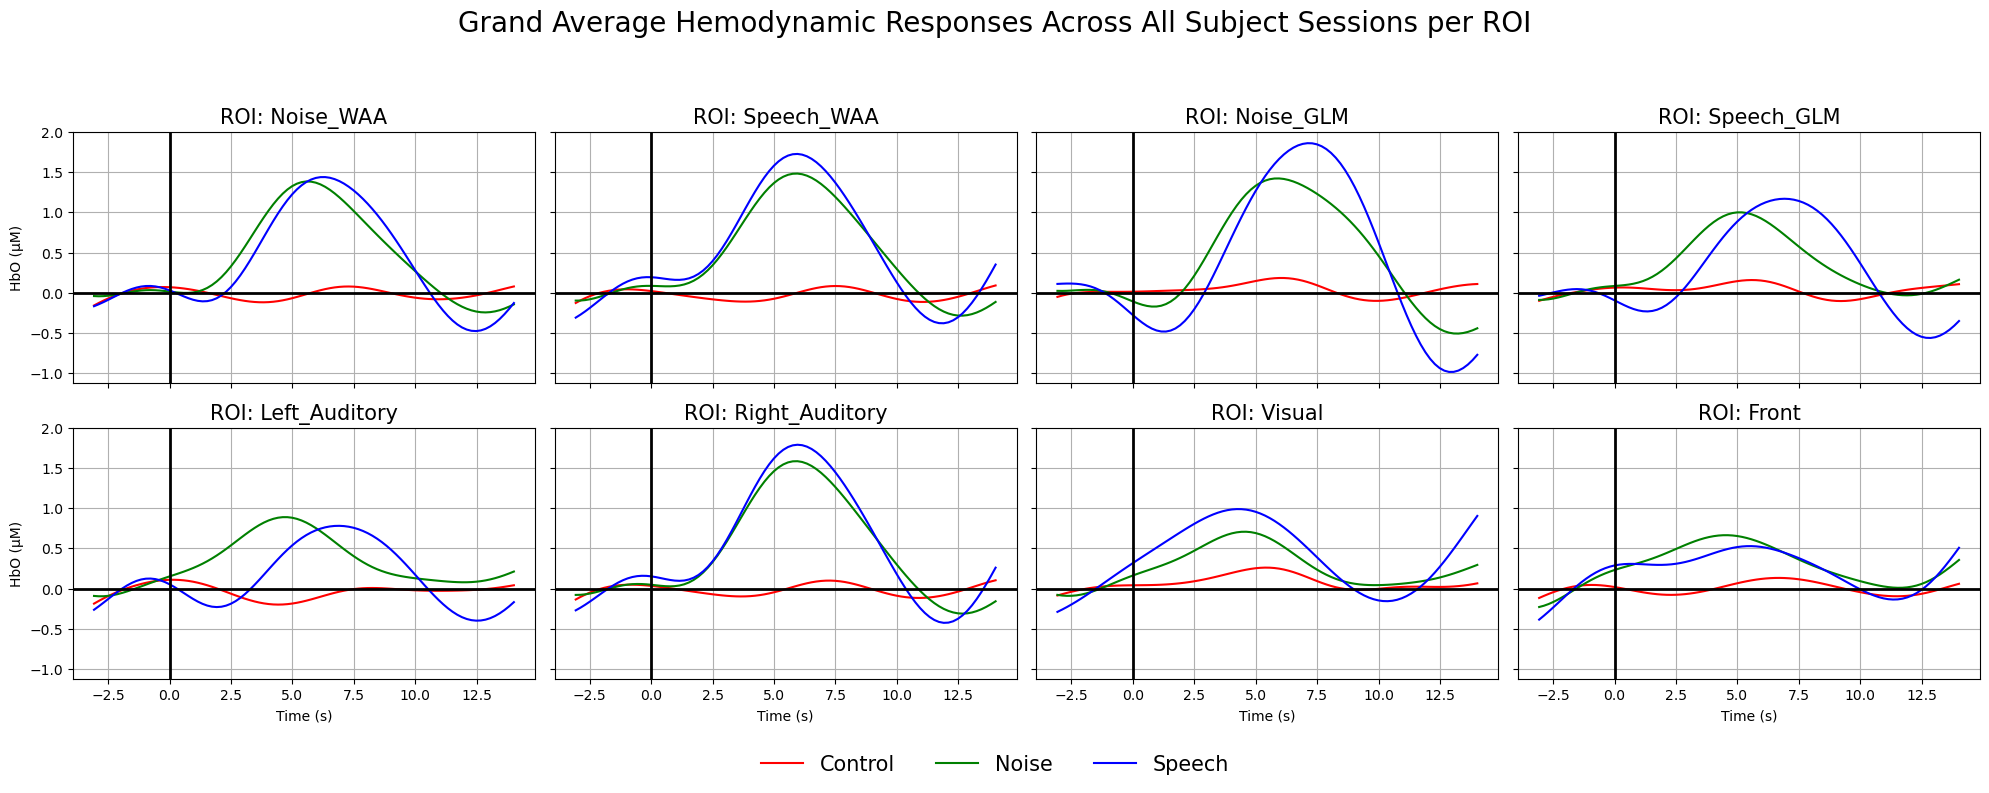

In [27]:
colors = {"Control": "r", "Noise": "g", "Speech": "b"}

num_rois = len(roi_condition_timeseries)
nrows, ncols = 2, 4  # For 8 ROIs
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (ax, (roi_name, condition_dict)) in enumerate(zip(axes, roi_condition_timeseries.items())):
    for condition_name, ts_list in condition_dict.items():
        ts_array = np.vstack(ts_list)
        mean_ts = ts_array.mean(axis=0) * 1e6  # µM
        std_ts = ts_array.std(axis=0) * 1e6

        ax.plot(time_vector, mean_ts, label=condition_name, color=colors.get(condition_name, 'k'))
        #ax.fill_between(time_vector, mean_ts - std_ts, mean_ts + std_ts, color=colors.get(condition_name, 'k'), alpha=0.2)

    # Add thick black lines at x=0 and y=0
    ax.axhline(0, color='black', linewidth=2)
    ax.axvline(0, color='black', linewidth=2)

    ax.set_title(f"ROI: {roi_name}", fontsize=15)
    ax.grid(True)

    # Label only the bottom row
    if i // ncols == nrows - 1:
        ax.set_xlabel("Time (s)")
    # Label only the first column
    if i % ncols == 0:
        ax.set_ylabel("HbO (µM)")

# Shared legend below all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, fontsize=15)

plt.suptitle("Grand Average Hemodynamic Responses Across All Subject Sessions per ROI", fontsize=20)
plt.tight_layout(rect=[0, 0.07, 1, 0.93])  # Adjust for title and legend
plt.show()

## Rquantity and Roverlap

### Control vs Noise

In [28]:
sig_ses1 = set(noise_sig_ses01['Optode'])
sig_ses2 = set(noise_sig_ses02['Optode'])

A1 = len(sig_ses1)
A2 = len(sig_ses2)
A_overlap = len(sig_ses1 & sig_ses2)

R_quantity = 1 - (abs(A1 - A2) / (A1 + A2)) if (A1 + A2) > 0 else float('nan')
R_overlap = (2 * A_overlap) / (A1 + A2) if (A1 + A2) > 0 else float('nan')

print(f"Session 01: {A1} significant channels")
print(f"Session 02: {A2} significant channels")
print(f"Overlap   : {A_overlap} channels")
print(f"R_quantity: {R_quantity:.2f}")
print(f"R_overlap : {R_overlap:.2f}")

Session 01: 1 significant channels
Session 02: 12 significant channels
Overlap   : 1 channels
R_quantity: 0.15
R_overlap : 0.15


### Control vs Speech

In [29]:
sig_ses1 = set(speech_sig_ses01['Optode'])
sig_ses2 = set(speech_sig_ses02['Optode'])

A1 = len(sig_ses1)
A2 = len(sig_ses2)
A_overlap = len(sig_ses1 & sig_ses2)

R_quantity = 1 - (abs(A1 - A2) / (A1 + A2)) if (A1 + A2) > 0 else float('nan')
R_overlap = (2 * A_overlap) / (A1 + A2) if (A1 + A2) > 0 else float('nan')

print(f"Session 01: {A1} significant channels")
print(f"Session 02: {A2} significant channels")
print(f"Overlap   : {A_overlap} channels")
print(f"R_quantity: {R_quantity:.2f}")
print(f"R_overlap : {R_overlap:.2f}")

Session 01: 6 significant channels
Session 02: 12 significant channels
Overlap   : 6 channels
R_quantity: 0.67
R_overlap : 0.67


# WAA Individual Level Analysis

## Channel-level processing

In [5]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()
ttest_results = []
roi_mean_values = []


for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )
        id += 1
        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

       # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()
        #speech_glm= [[6, 8], [9, 8]] 
        #noise_glm=[[6, 8]] 
        all_rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }

        
        ## ttest for significant differences between conditions
        tmin, tmax = 4.25, 6.75
        for roi_name, optode_list in all_rois.items():
            available_optodes = [opt for opt in optode_list if opt in epochs_cleaned.info["ch_names"]]
            if len(available_optodes) < 1:
                continue

            try:
                cond_data = {}
                cond_means = {}
                
                for cond in ["Control", "Noise", "Speech"]:
                    cond_epochs = epochs_cleaned[cond].copy().pick(available_optodes).crop(tmin=tmin, tmax=tmax)
                    data = cond_epochs.get_data()
                    roi_values = data.mean(axis=1).mean(axis=1) * 1e6  # µM
                    cond_data[cond] = roi_values
                    cond_means[cond] = np.mean(roi_values)

                # Store mean values for summary
                roi_mean_values.append({
                    "ID": id,
                    "Subject": sub,
                    "Session": f"{ses:02d}",
                    "ROI": roi_name,
                    "Mean_Control": cond_means["Control"],
                    "Mean_Noise": cond_means["Noise"],
                    "Mean_Speech": cond_means["Speech"]
                })

                # Run t-tests
                if len(cond_data["Control"]) > 1 and len(cond_data["Noise"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Noise"], equal_var=False, alternative='less')
                    effect = cond_means["Noise"] - cond_means["Control"]
                    ttest_results.append({
                        "ID": id,
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Noise", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

                if len(cond_data["Control"]) > 1 and len(cond_data["Speech"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Speech"], equal_var=False, alternative='less')
                    effect = cond_means["Speech"] - cond_means["Control"]
                    ttest_results.append({
                        "ID": id,
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Speech", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

            except Exception as e:
                print(f"Error testing {roi_name} for Subject {sub}, Session {ses:02d}: {e}")

# === Save results ===
df_ttest = pd.DataFrame(ttest_results)

df_roi_means = pd.DataFrame(roi_mean_values)


# === Summary per participant ===
print("\n=== Significant ROI Summary per Participant ===")
df_significant = df_ttest[df_ttest["p_value"] < 0.05]
if df_significant.empty:
    print("No significant ROIs found.")
else:
    grouped = df_significant.groupby(["Subject", "Session"])
    for (sub, ses), group in grouped:
        print(f"\nSubject: {sub}, Session: {ses}")
        for _, row in group.iterrows():
            sign = "↑" if row["Effect"] > 0 else "↓"
            print(f"  - {row['ROI']} ({row['Comparison']}): p = {row['p_value']:.4f}, effect = {row['Effect']:.4f} ({sign})")




Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

### FDR correction

#### Control vs Noise

In [13]:
df_con_noise = df_ttest[df_ttest["Comparison"] == "Control vs Noise"].copy()

# Store significant optodes
significant_optodes_list_noise = []

q = 0.05
unique_subjects = df_con_noise["Subject"].unique()
unique_sessions = df_con_noise["Session"].unique()

for subject in unique_subjects:
    for ses in unique_sessions:
        print(f"Processing subject {subject}, session {ses}...")
        df_con_noise_single = df_con_noise[
            (df_con_noise["Subject"] == subject) & 
            (df_con_noise["Session"] == ses)
        ].copy()

        if df_con_noise_single.empty:
            print(f"No data for subject {subject}, session {ses}. Skipping...")
            continue

        df_con_noise_single["p_value"] = pd.to_numeric(df_con_noise_single["p_value"], errors='coerce')
        df_con_noise_single = df_con_noise_single.dropna(subset=["p_value"])
        unique_channels = df_con_noise_single["ROI"].unique()
        m = len(unique_channels)  # number of independent tests
        print(f"Number of independent tests (m): {m}")

        sorted_df = df_con_noise_single.sort_values("p_value").reset_index(drop=True)

        for i in range(len(sorted_df)):
            p_val = sorted_df.loc[i, "p_value"]
            threshold = (q * (i + 1)) / m
            ch_name = sorted_df.loc[i, "ROI"]

            if p_val <= threshold:
                print(f"Optode {ch_name} is significant with p-value {p_val} and threshold {threshold}")
                significant_optodes_list_noise.append({
                    "Subject": subject,
                    "Session": ses,
                    "ROI": ch_name,
                    "p_value": p_val
                })
            else:
                print(f"Optode {ch_name} is not significant with p-value {p_val} and threshold {threshold}")
            

Processing subject 01, session 01...
Number of independent tests (m): 20
Optode S5_D2 is significant with p-value 0.0008284256851972744 and threshold 0.0025
Optode S10_D11 is significant with p-value 0.0009144591274068446 and threshold 0.005
Optode S8_D7 is significant with p-value 0.0011482283553732053 and threshold 0.0075000000000000015
Optode S7_D7 is significant with p-value 0.0026243277432241537 and threshold 0.01
Optode S4_D3 is significant with p-value 0.003489403446884542 and threshold 0.0125
Optode S10_D12 is significant with p-value 0.004022865927070211 and threshold 0.015000000000000003
Optode S5_D3 is significant with p-value 0.005220297611372783 and threshold 0.0175
Optode S10_D9 is significant with p-value 0.013582269682163587 and threshold 0.02
Optode S1_D1 is not significant with p-value 0.026362467183618413 and threshold 0.0225
Optode S8_D8 is not significant with p-value 0.044836816018574074 and threshold 0.025
Optode S10_D10 is not significant with p-value 0.05206917

#### Control vs Speech

In [11]:
df_con_speech = df_ttest[df_ttest["Comparison"] == "Control vs Speech"].copy()

# Store significant optodes
significant_optodes_list_speech = []


q = 0.05
unique_subjects = df_con_speech["Subject"].unique()
unique_sessions = df_con_speech["Session"].unique()

for subject in unique_subjects:
    for ses in unique_sessions:
        print(f"Processing subject {subject}, session {ses}...")
        df_con_speech_single = df_con_speech[
            (df_con_speech["Subject"] == subject) & 
            (df_con_speech["Session"] == ses)
        ].copy()

        if df_con_speech_single.empty:
            print(f"No data for subject {subject}, session {ses}. Skipping...")
            continue

        df_con_speech_single["p_value"] = pd.to_numeric(df_con_speech_single["p_value"], errors='coerce')
        df_con_speech_single = df_con_speech_single.dropna(subset=["p_value"])
        unique_channels = df_con_speech_single["ROI"].unique()
        m = len(unique_channels)  # number of independent tests
        print(f"Number of independent tests (m): {m}")

        sorted_df = df_con_speech_single.sort_values("p_value").reset_index(drop=True)

        for i in range(len(sorted_df)):
            p_val = sorted_df.loc[i, "p_value"]
            threshold = (q * (i + 1)) / m
            ch_name = sorted_df.loc[i, "ROI"]

            if p_val <= threshold:
                print(f"Optode {ch_name} is significant with p-value {p_val} and threshold {threshold}")
                significant_optodes_list_speech.append({
                    "Subject": subject,
                    "Session": ses,
                    "ROI": ch_name,
                    "p_value": p_val
                })
            else:
                print(f"Optode {ch_name} is not significant with p-value {p_val} and threshold {threshold}")
            

Processing subject 01, session 01...
Number of independent tests (m): 20
Optode S8_D7 is not significant with p-value 0.0033262741078902013 and threshold 0.0025
Optode S5_D2 is significant with p-value 0.00466407458775672 and threshold 0.005
Optode S10_D12 is not significant with p-value 0.008616229394500742 and threshold 0.0075000000000000015
Optode S5_D4 is not significant with p-value 0.01086243908366802 and threshold 0.01
Optode S5_D3 is significant with p-value 0.010957801754073269 and threshold 0.0125
Optode S11_D12 is significant with p-value 0.013556868396370504 and threshold 0.015000000000000003
Optode S7_D7 is not significant with p-value 0.02141380529836268 and threshold 0.0175
Optode S10_D11 is not significant with p-value 0.021669138404518975 and threshold 0.02
Optode S1_D1 is not significant with p-value 0.03965236691810951 and threshold 0.0225
Optode S2_D1 is not significant with p-value 0.041500476847552384 and threshold 0.025
Optode S12_D1 is not significant with p-val

### Channel-Activation Counts Figure

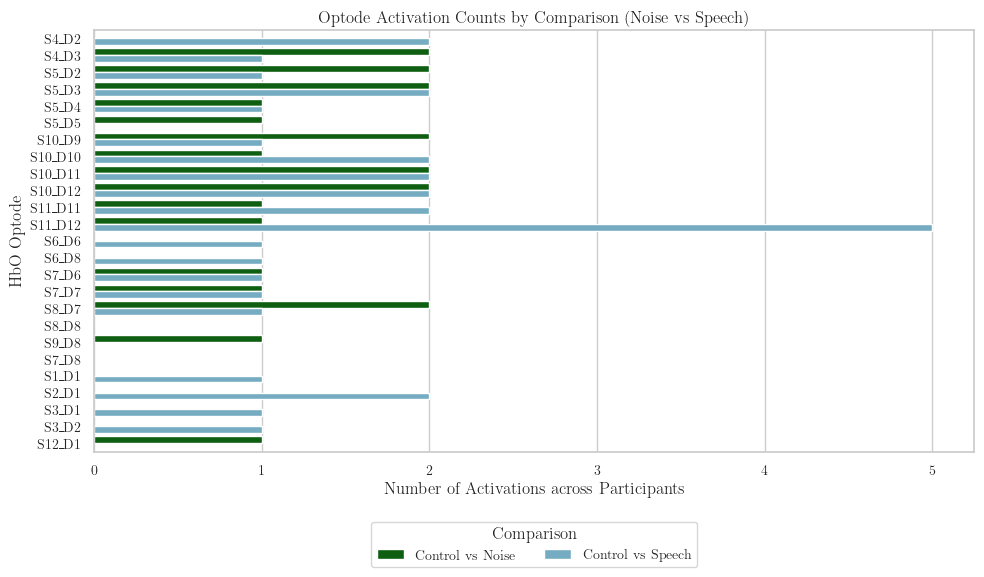

In [15]:
# --- Convert Noise list to DataFrame ---
df_sig_noise = pd.DataFrame(significant_optodes_list_noise)
df_sig_noise["ROI"] = df_sig_noise["ROI"].str.replace(" hbo", "", regex=False)

counts_noise = (
    df_sig_noise.groupby("ROI")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_noise["Comparison"] = "Control vs Noise"
counts_noise.rename(columns={"ROI": "ROI"}, inplace=True)

# --- Convert Speech list to DataFrame ---
df_sig_speech = pd.DataFrame(significant_optodes_list_speech)
df_sig_speech["ROI"] = df_sig_speech["ROI"].str.replace(" hbo", "", regex=False)

counts_speech = (
    df_sig_speech.groupby("ROI")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_speech["Comparison"] = "Control vs Speech"
counts_speech.rename(columns={"ROI": "ROI"}, inplace=True)

# --- Combine both DataFrames ---
roi_counts = pd.concat([counts_noise, counts_speech], ignore_index=True)

# --- Predefined Optode (ROI) Order ---
roi_order = [
    "S4_D2", "S4_D3", "S5_D2", "S5_D3", "S5_D4", "S5_D5",
    "S10_D9", "S10_D10", "S10_D11", "S10_D12", "S11_D11", "S11_D12",
    "S6_D6", "S6_D8", "S7_D6", "S7_D7", "S8_D7", "S8_D8",
    "S9_D8", "S7_D8", "S1_D1", "S2_D1", "S3_D1", "S3_D2", "S12_D1"
]

# --- Plotting ---
sns.set(style="whitegrid")

# Use two distinct colors for Noise and Speech
custom_palette = {
    "Control vs Noise": "#006D04",   # Green
    "Control vs Speech": "#69B1CE"   # Blue
}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=roi_counts,
    x="Count",
    y="ROI",
    hue="Comparison",
    order=roi_order,
    palette=custom_palette
)

plt.title("Optode Activation Counts by Comparison (Noise vs Speech)")
plt.xlabel("Number of Activations across Participants")
plt.ylabel("HbO Optode")
plt.legend(
    title="Comparison",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)
plt.tight_layout()
plt.show()


### Rquantity Roverlap

#### Control vs Noise

In [28]:

# Filter for significant optodes only for noise
df_sig_noise = df_significant[df_significant["Comparison"] == "Control vs Noise"].copy()

# Get unique subjects
subjects = df_sig_noise["Subject"].unique()

# For each subject, calculate R_overlap
for subj in sorted(subjects):
    # Filter data for the subject
    subj_data = df_sig_noise[df_sig_noise["Subject"] == subj]
    
               

    # Get channels for each session
    ses1_channels = set(subj_data[subj_data["Session"] == "01"]["ROI"])
    ses2_channels = set(subj_data[subj_data["Session"] == "02"]["ROI"])

    # Calculate activation quantities
    A1 = len(ses1_channels)
    A2 = len(ses2_channels)
    A_overlap = len(ses1_channels.intersection(ses2_channels))

    # Compute R_overlap safely (avoid division by zero)
    if (A1 + A2) > 0:
        R_quantity= 1- ((abs(A1 - A2) )/ (A1 + A2))
        R_overlap = (2 * A_overlap) / (A1 + A2)
    else:
        R_quantity = float('nan') 
        R_overlap = float('nan')

    print(f"Subject {subj}")
    print(f"  Session 01 significant channels ({A1}): {sorted(ses1_channels)}")
    print(f"  Session 02 significant channels ({A2}): {sorted(ses2_channels)}")
    print(f"  Overlapping channels ({A_overlap}): {sorted(ses1_channels.intersection(ses2_channels))}")
    print(f"  R_quantity: {R_quantity:.3f}")
    print(f"  R_overlap: {R_overlap:.3f}")
    
    print()


Subject 01
  Session 01 significant channels (10): ['S10_D11', 'S10_D12', 'S10_D9', 'S1_D1', 'S4_D3', 'S5_D2', 'S5_D3', 'S7_D7', 'S8_D7', 'S8_D8']
  Session 02 significant channels (0): []
  Overlapping channels (0): []
  R_quantity: 0.000
  R_overlap: 0.000

Subject 02
  Session 01 significant channels (0): []
  Session 02 significant channels (12): ['S10_D10', 'S10_D11', 'S10_D12', 'S10_D9', 'S11_D11', 'S11_D12', 'S12_D1', 'S4_D3', 'S5_D2', 'S5_D3', 'S5_D4', 'S5_D5']
  Overlapping channels (0): []
  R_quantity: 0.000
  R_overlap: 0.000

Subject 03
  Session 01 significant channels (1): ['S10_D11']
  Session 02 significant channels (14): ['S10_D10', 'S10_D11', 'S10_D9', 'S1_D1', 'S3_D1', 'S4_D3', 'S5_D2', 'S5_D4', 'S5_D5', 'S7_D6', 'S7_D7', 'S7_D8', 'S8_D7', 'S9_D8']
  Overlapping channels (1): ['S10_D11']
  R_quantity: 0.133
  R_overlap: 0.133

Subject 04
  Session 01 significant channels (6): ['S10_D12', 'S4_D2', 'S4_D3', 'S5_D2', 'S6_D8', 'S7_D8']
  Session 02 significant channels 

#### Control vs Speech

In [29]:

# Filter for significant optodes only for noise
df_sig_speech= df_significant[df_significant["Comparison"] == "Control vs Speech"].copy()

# Get unique subjects
subjects = df_sig_speech["Subject"].unique()

# For each subject, calculate R_overlap
for subj in sorted(subjects):
    # Filter data for the subject
    subj_data = df_sig_speech[df_sig_speech["Subject"] == subj]
    
               

    # Get channels for each session
    ses1_channels = set(subj_data[subj_data["Session"] == "01"]["ROI"])
    ses2_channels = set(subj_data[subj_data["Session"] == "02"]["ROI"])

    # Calculate activation quantities
    A1 = len(ses1_channels)
    A2 = len(ses2_channels)
    A_overlap = len(ses1_channels.intersection(ses2_channels))

    # Compute R_overlap safely (avoid division by zero)
    if (A1 + A2) > 0:
        R_quantity= 1- ((abs(A1 - A2) )/ (A1 + A2))
        R_overlap = (2 * A_overlap) / (A1 + A2)
    else:
        R_quantity = float('nan') 
        R_overlap = float('nan')

    print(f"Subject {subj}")
    print(f"  Session 01 significant channels ({A1}): {sorted(ses1_channels)}")
    print(f"  Session 02 significant channels ({A2}): {sorted(ses2_channels)}")
    print(f"  Overlapping channels ({A_overlap}): {sorted(ses1_channels.intersection(ses2_channels))}")
    print(f"  R_overlap: {R_overlap:.3f}")
    print(f"  R_quantity: {R_quantity:.3f}")
    print()


Subject 01
  Session 01 significant channels (12): ['S10_D11', 'S10_D12', 'S11_D12', 'S12_D1', 'S1_D1', 'S2_D1', 'S4_D3', 'S5_D2', 'S5_D3', 'S5_D4', 'S7_D7', 'S8_D7']
  Session 02 significant channels (3): ['S10_D11', 'S10_D12', 'S12_D1']
  Overlapping channels (3): ['S10_D11', 'S10_D12', 'S12_D1']
  R_overlap: 0.400
  R_quantity: 0.400

Subject 02
  Session 01 significant channels (1): ['S11_D12']
  Session 02 significant channels (10): ['S10_D10', 'S10_D11', 'S10_D12', 'S10_D9', 'S11_D11', 'S11_D12', 'S12_D1', 'S4_D3', 'S5_D2', 'S5_D5']
  Overlapping channels (1): ['S11_D12']
  R_overlap: 0.182
  R_quantity: 0.182

Subject 03
  Session 01 significant channels (0): []
  Session 02 significant channels (5): ['S10_D10', 'S1_D1', 'S7_D6', 'S8_D7', 'S9_D8']
  Overlapping channels (0): []
  R_overlap: 0.000
  R_quantity: 0.000

Subject 04
  Session 01 significant channels (3): ['S10_D11', 'S4_D3', 'S9_D8']
  Session 02 significant channels (3): ['S10_D11', 'S3_D2', 'S5_D3']
  Overlapping c

## ROI-level processing

### Threshold (same for GLM)

In [56]:
# get individual_roi_results from the previous analysis
print("\n=== Individual ROI Results ===")
individual_roi_results


=== Individual ROI Results ===


,Subject,Session,ROI,Significant_Noise,Significant_Speech,Value_Control,Value_Noise,Value_Speech
0,01,01,Front,True,True,-0.208556,0.016895,0.841137
1,01,01,Left_Auditory,True,True,-0.889080,2.167188,2.385723
2,01,01,Noise_GLM,True,True,0.137718,1.533091,1.951870
3,01,01,Noise_WAA,True,True,-0.808572,3.486440,2.438040
4,01,01,Right_Auditory,True,True,-1.366142,3.844267,2.532322
...,...,...,...,...,...,...,...,...
251,24,02,Noise_WAA,True,True,-1.720442,2.555871,4.884566
252,24,02,Right_Auditory,True,True,-2.421249,3.012518,5.890588
253,24,02,Speech_GLM,True,True,-1.544985,3.255048,3.713390
254,24,02,Speech_WAA,True,True,-2.325351,3.047036,5.746514


### Epoch ttest

In [48]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()
ttest_results = []
roi_mean_values = []


for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )
        id += 1
        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

       # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()
       
        
        data_driven_rois = {
            "Noise_WAA": ["S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo", "S10_D9 hbo", "S6_D8 hbo", "S4_D2 hbo"],
            "Speech_WAA": ["S10_D11 hbo", "S11_D12 hbo", "S5_D4 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D12 hbo", "S11_D11 hbo"],
            "Noise_GLM": ["S11_D12 hbo", "S11_D11 hbo"],
            "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S7_D7 hbo", "S4_D2 hbo", "S9_D8 hbo", "S4_D3 hbo"]
        }

        
        predefined_rois = {
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"]
        }
        
        all_rois= {**data_driven_rois, **predefined_rois}

        
        ## ttest for significant differences between conditions
        tmin, tmax = 4.25, 6.75
        for roi_name, optode_list in all_rois.items():
            available_optodes = [opt for opt in optode_list if opt in epochs_cleaned.info["ch_names"]]
            if len(available_optodes) < 1:
                continue

            try:
                cond_data = {}
                cond_means = {}
                
                for cond in ["Control", "Noise", "Speech"]:
                    cond_epochs = epochs_cleaned[cond].copy().pick(available_optodes).crop(tmin=tmin, tmax=tmax)
                    data = cond_epochs.get_data()
                    roi_values = data.mean(axis=1).mean(axis=1) * 1e6  # µM
                    cond_data[cond] = roi_values
                    cond_means[cond] = np.mean(roi_values)

                # Store mean values for summary
                roi_mean_values.append({
                    "ID": id,
                    "Subject": sub,
                    "Session": f"{ses:02d}",
                    "ROI": roi_name,
                    "Mean_Control": cond_means["Control"],
                    "Mean_Noise": cond_means["Noise"],
                    "Mean_Speech": cond_means["Speech"]
                })

                # Run t-tests
                if len(cond_data["Control"]) > 1 and len(cond_data["Noise"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Noise"], equal_var=False, alternative='less')
                    effect = cond_means["Noise"] - cond_means["Control"]
                    ttest_results.append({
                        "ID": id,
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Noise", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

                if len(cond_data["Control"]) > 1 and len(cond_data["Speech"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Speech"], equal_var=False, alternative='less')
                    effect = cond_means["Speech"] - cond_means["Control"]
                    ttest_results.append({
                        "ID": id,
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Speech", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

            except Exception as e:
                print(f"Error testing {roi_name} for Subject {sub}, Session {ses:02d}: {e}")

# === Save results ===
df_ttest = pd.DataFrame(ttest_results)

df_roi_means = pd.DataFrame(roi_mean_values)


# === Summary per participant ===
print("\n=== Significant ROI Summary per Participant ===")
df_significant = df_ttest[df_ttest["p_value"] < 0.05]
if df_significant.empty:
    print("No significant ROIs found.")
else:
    grouped = df_significant.groupby(["Subject", "Session"])
    for (sub, ses), group in grouped:
        print(f"\nSubject: {sub}, Session: {ses}")
        for _, row in group.iterrows():
            sign = "↑" if row["Effect"] > 0 else "↓"
            print(f"  - {row['ROI']} ({row['Comparison']}): p = {row['p_value']:.4f}, effect = {row['Effect']:.4f} ({sign})")




Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 1 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 1 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 1

### FDR Correction

In [ ]:
unique_id = df_ttest["ID"].unique()
comparisons = ["Control vs Noise", "Control vs Speech"]
m = 16  # number of independent tests (number of ROIs × 2 comparisons)
q = 0.05

for ids in unique_id:
    print(f"\nParticipant ID: {ids}")
    
    df_id = df_ttest[df_ttest["ID"] == ids]
    if df_id.empty:
        print("No data for this participant.")
        continue
    
    for comp in comparisons:
        df_participant = df_id[df_id["Comparison"] == comp].copy()
        
        if df_participant.empty:
            print(f"No data for comparison {comp}.")
            continue
        
        subject = df_participant["Subject"].values[0]
        session = df_participant["Session"].values[0]
        print(f"Subject number: {subject}, Session: {session}")
        print(f"Comparison: {comp}")
        
        # Sort the DataFrame by p-value
        df_sorted = df_participant.sort_values("p_value").reset_index(drop=True)
        
        significant_any = False
        for i in range(len(df_sorted)):
            p_val = df_sorted.loc[i, "p_value"]
            threshold = (q * (i + 1)) / m
            roi = df_sorted.loc[i, "ROI"]
            
            if p_val <= threshold:
                significant_any = True
                print(f"ROI {roi} is significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
            else:
                print(f"ROI {roi} is not significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
        
        if not significant_any:
            print("No significant p-values after FDR correction.")



Participant ID: 1
Subject number: 01, Session: 01
Comparison: Control vs Noise
ROI Right_Auditory is significant with p-value 0.0001 and threshold 0.0063
ROI Noise_WAA is significant with p-value 0.0001 and threshold 0.0125
ROI Speech_WAA is significant with p-value 0.0001 and threshold 0.0188
ROI Visual is significant with p-value 0.0004 and threshold 0.0250
ROI Left_Auditory is significant with p-value 0.0017 and threshold 0.0312
ROI Speech_GLM is significant with p-value 0.0049 and threshold 0.0375
ROI Noise_GLM is not significant with p-value 0.0492 and threshold 0.0438
ROI Front is not significant with p-value 0.3897 and threshold 0.0500
Subject number: 01, Session: 01
Comparison: Control vs Speech
ROI Speech_WAA is significant with p-value 0.0024 and threshold 0.0063
ROI Noise_WAA is significant with p-value 0.0031 and threshold 0.0125
ROI Left_Auditory is significant with p-value 0.0034 and threshold 0.0188
ROI Right_Auditory is significant with p-value 0.0036 and threshold 0.0

# ICC(2,1)

## ROIs

In [35]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
    "Noise_WAA": ["S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo", "S10_D9 hbo", "S6_D8 hbo", "S4_D2 hbo"],
    "Speech_WAA": ["S10_D11 hbo", "S11_D12 hbo", "S5_D4 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D12 hbo", "S11_D11 hbo"],
    "Noise_GLM": ["S11_D12 hbo", "S11_D11 hbo"],
    "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S7_D7 hbo", "S4_D2 hbo", "S9_D8 hbo", "S4_D3 hbo"],
    
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "Session", "Condition"])["Value"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "Session": "raters",
        "Value": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores")

    icc_2_1 = icc[icc["Type"] == "ICC2"].iloc[0]  # ICC(2,1)


    results_list.append({
        "ROI": roi_name,
        "ICC": icc_2_1["ICC"],
        "pval": icc_2_1["pval"]
    })


# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: Noise_WAA
Processing ROI: Speech_WAA
Processing ROI: Noise_GLM
Processing ROI: Speech_GLM
Processing ROI: Left_Auditory
Processing ROI: Right_Auditory
Processing ROI: Visual
Processing ROI: Front
✅ ICC results saved to 'icc_results_combined_conditions.csv'


### Bland-Altmann ROI plot

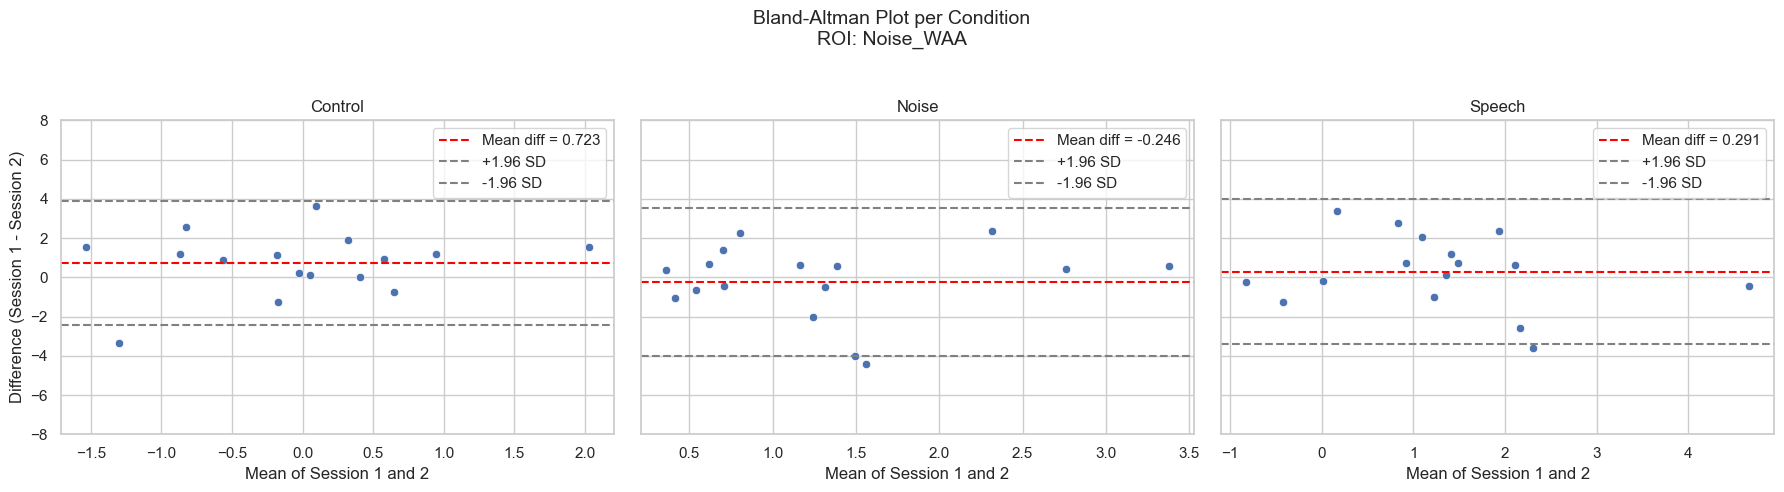

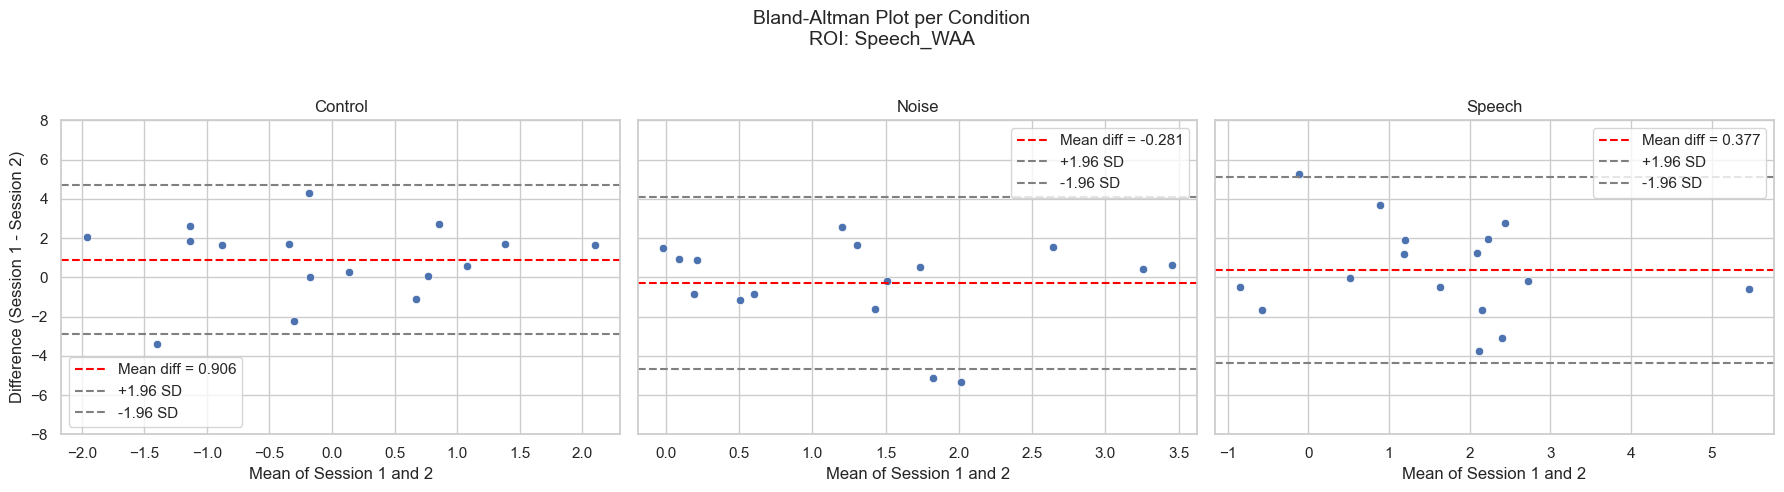

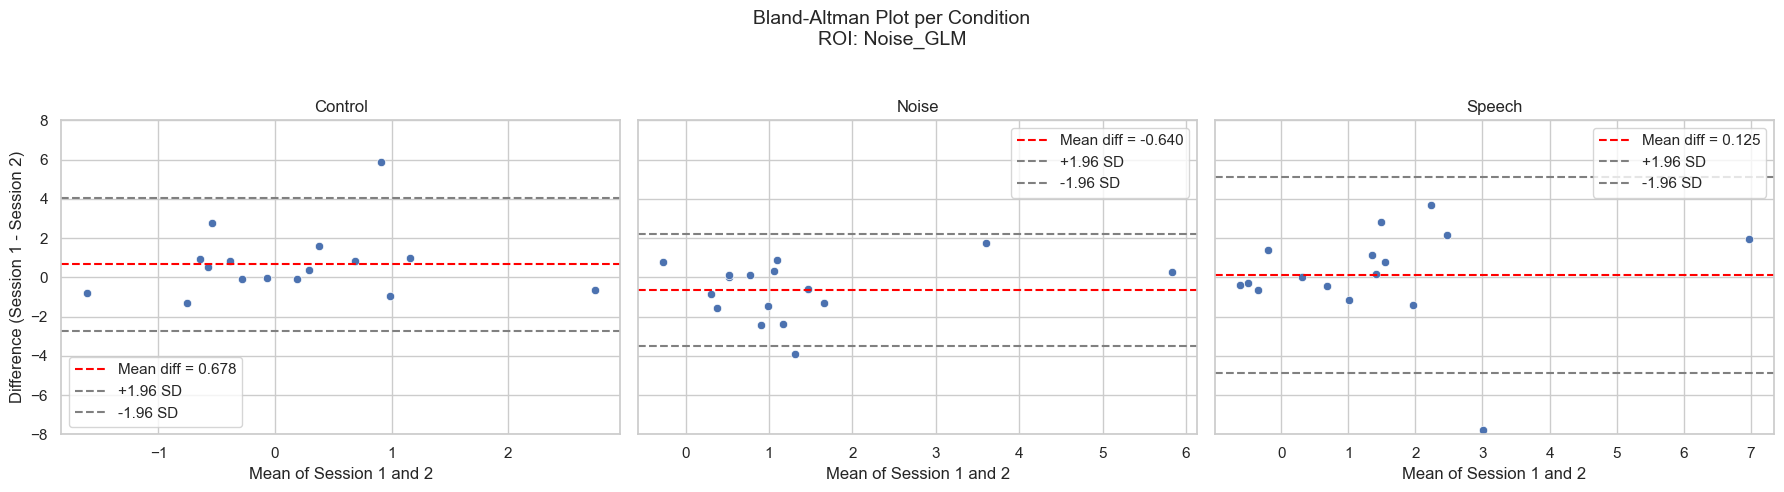

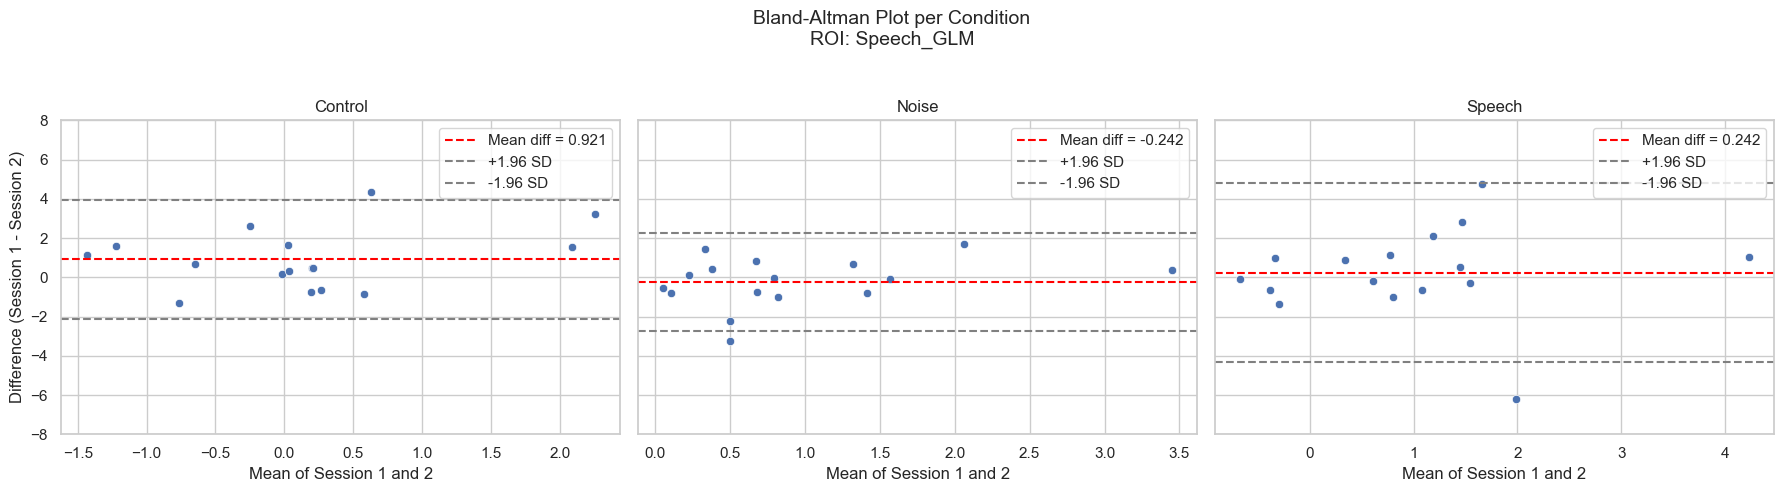

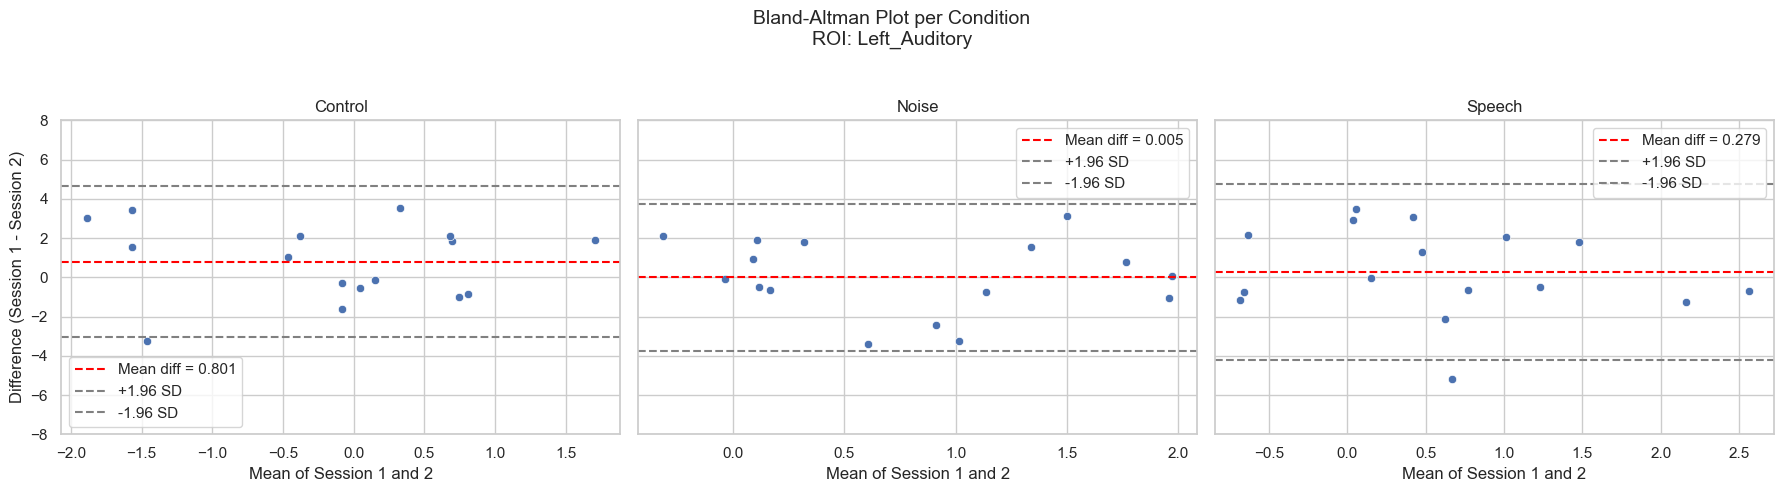

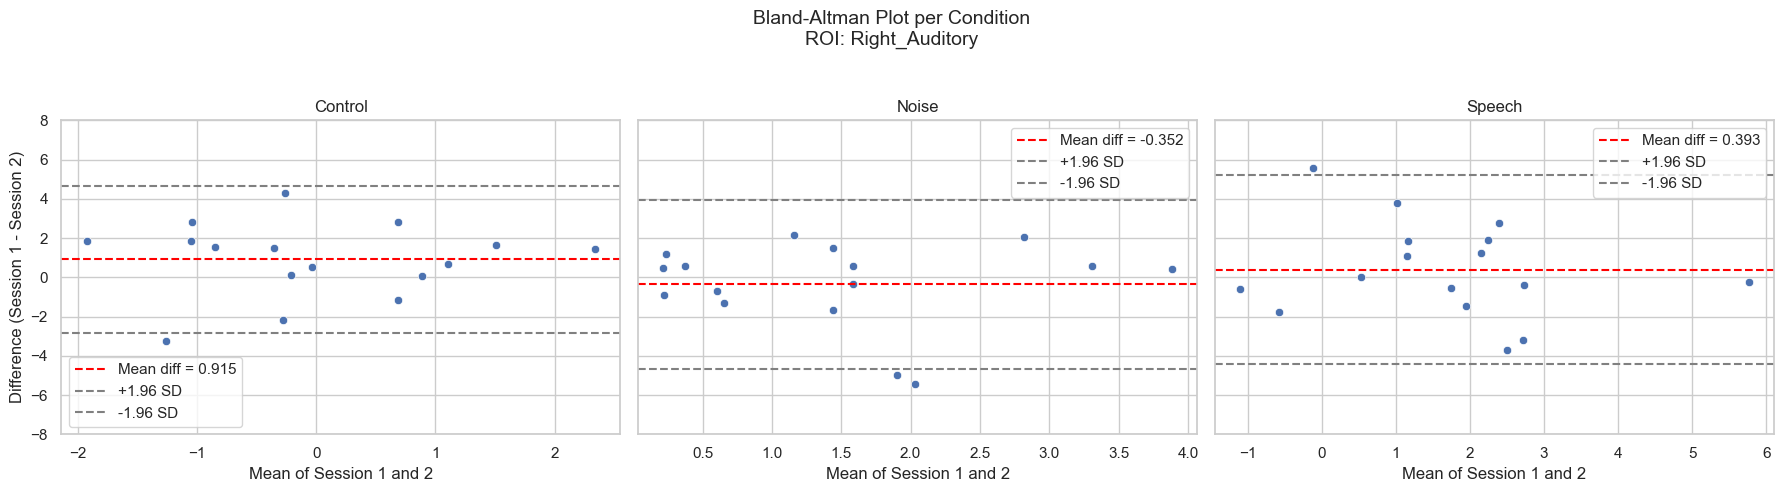

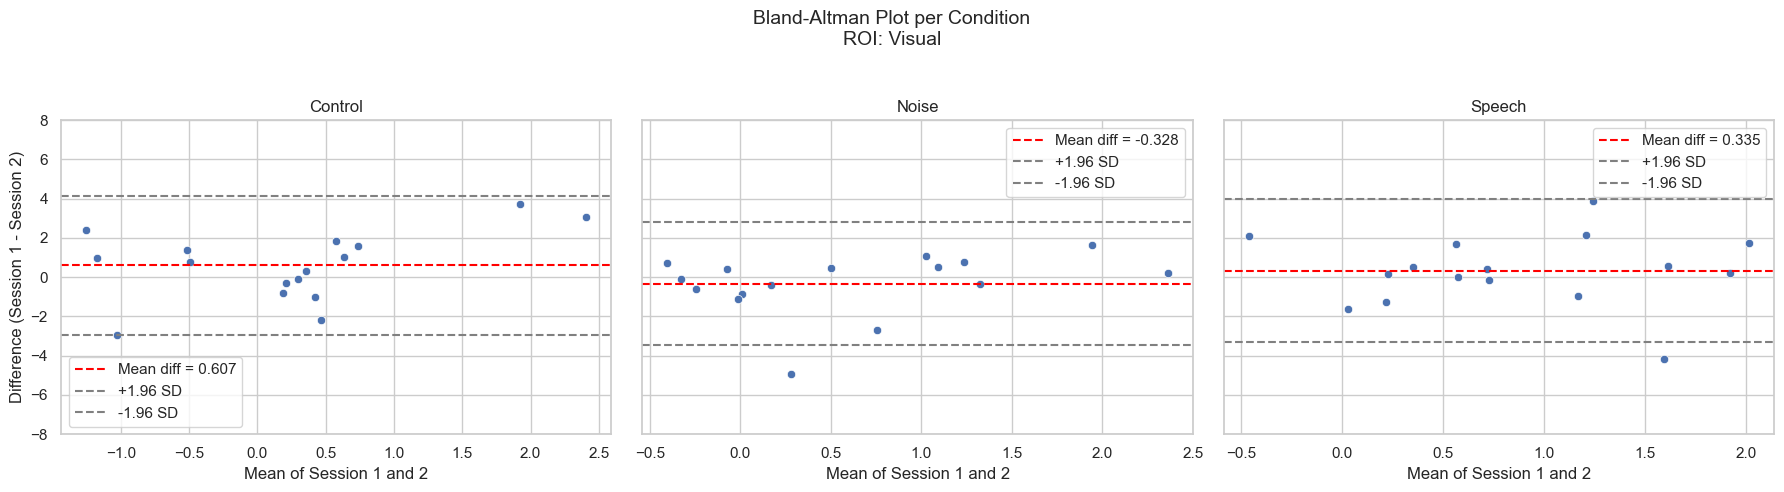

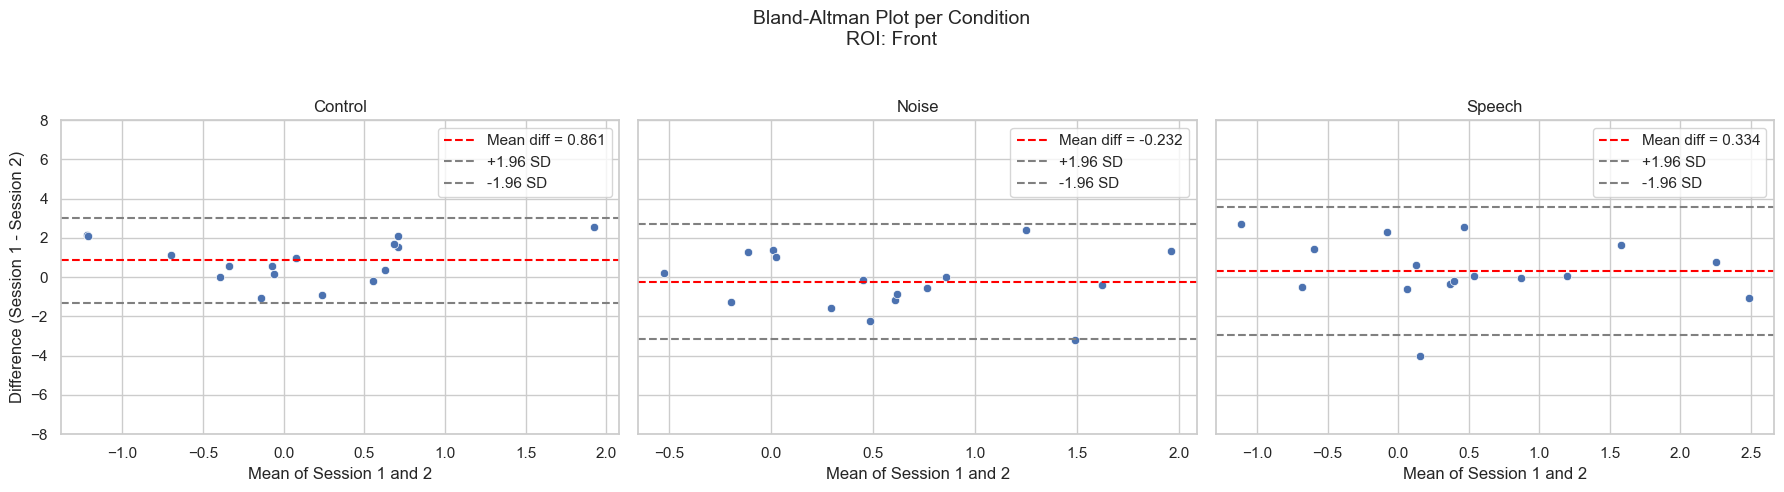

In [36]:
# Get unique experimental conditions
conditions = df_combined["Condition"].unique()
df_combined["Session"] = df_combined["Session"].astype(str).str.zfill(2)

# --- Bland-Altman plots per ROI and condition ---
for roi_name, optodes in rois.items():
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5), sharey=True)
    if len(conditions) == 1:
        axes = [axes]  # Ensure iterable if only one condition

    for ax, condition in zip(axes, conditions):
        # Filter data for current ROI and condition
        subset = df_combined[
            (df_combined["Optode"].isin(optodes)) & 
            (df_combined["Condition"] == condition)
        ]

        # Average over optodes for each subject and session
        mean_vals = subset.groupby(["Subject", "Session"])["Value"].mean().reset_index()

        # Pivot so each subject has session 01 and 02 as columns
        pivot = mean_vals.pivot(index="Subject", columns="Session", values="Value").dropna()

        if pivot.shape[0] < 2:
            ax.set_title(f'{condition}\nNot enough data')
            ax.axis('off')
            continue

        # Bland-Altman calculations
        session1 = pivot["01"]
        session2 = pivot["02"]
        avg = (session1 + session2) / 2
        diff = session1 - session2
        mean_diff = diff.mean()
        std_diff = diff.std()

        # Plot
        sns.scatterplot(x=avg, y=diff, ax=ax)
        ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.3f}')
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
        ax.set_title(f'{condition}')
        ax.set_xlabel('Mean of Session 1 and 2')
        if ax == axes[0]:
            ax.set_ylabel('Difference (Session 1 - Session 2)')
            ax.set_ylim(-8, 8)
        else:
            ax.set_ylabel('')
        ax.legend()

    plt.suptitle(f'Bland-Altman Plot per Condition\nROI: {roi_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Optodes

In [37]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "Session", "Condition"])["Value"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "Session": "raters",
        "Value": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores", nan_policy="omit")

    icc_2_1 = icc[icc["Type"] == "ICC2"].iloc[0]  # ICC(2,1)

    results_list.append({
        "ROI": roi_name,
        "ICC": icc_2_1["ICC"],
        "pval": icc_2_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions_optodes.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions_optodes.csv'")


Processing ROI: S4_D2
Processing ROI: S4_D3
Processing ROI: S5_D2
Processing ROI: S5_D3
Processing ROI: S5_D4
Processing ROI: S5_D5
Processing ROI: S10_D9
Processing ROI: S10_D10
Processing ROI: S10_D11
Processing ROI: S10_D12
Processing ROI: S11_D11
Processing ROI: S11_D12
Processing ROI: S6_D6
Processing ROI: S6_D8
Processing ROI: S7_D6
Processing ROI: S7_D7
Processing ROI: S8_D7
Processing ROI: S8_D8
Processing ROI: S9_D8
Processing ROI: S7_D8
Processing ROI: S1_D1
Processing ROI: S2_D1
Processing ROI: S3_D1
Processing ROI: S3_D2
Processing ROI: S12_D1
✅ ICC results saved to 'icc_results_combined_conditions_optodes.csv'


### Bland-Altmann Optode plot

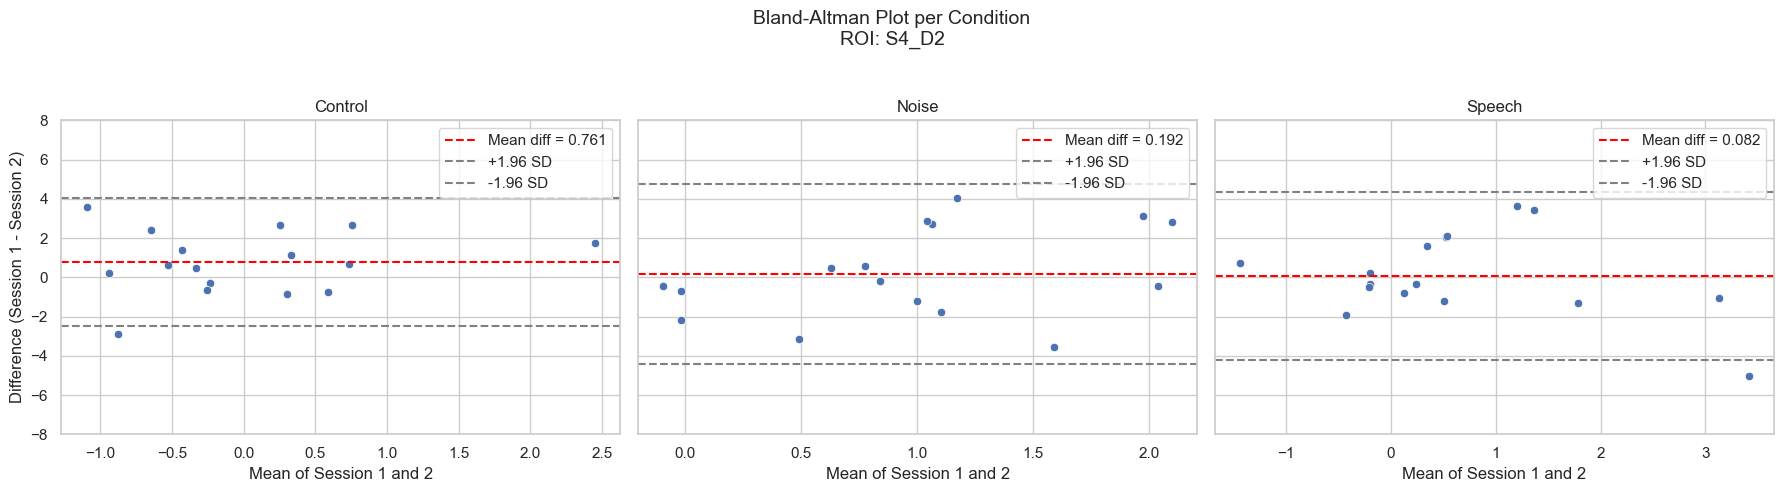

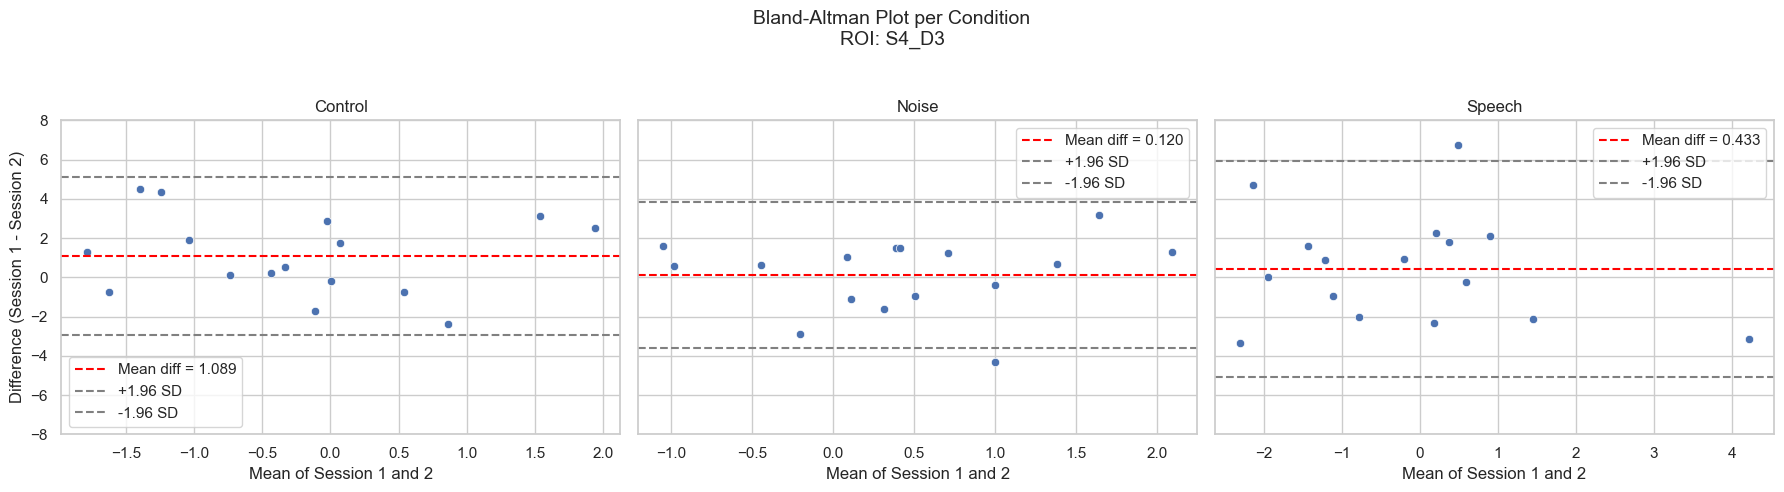

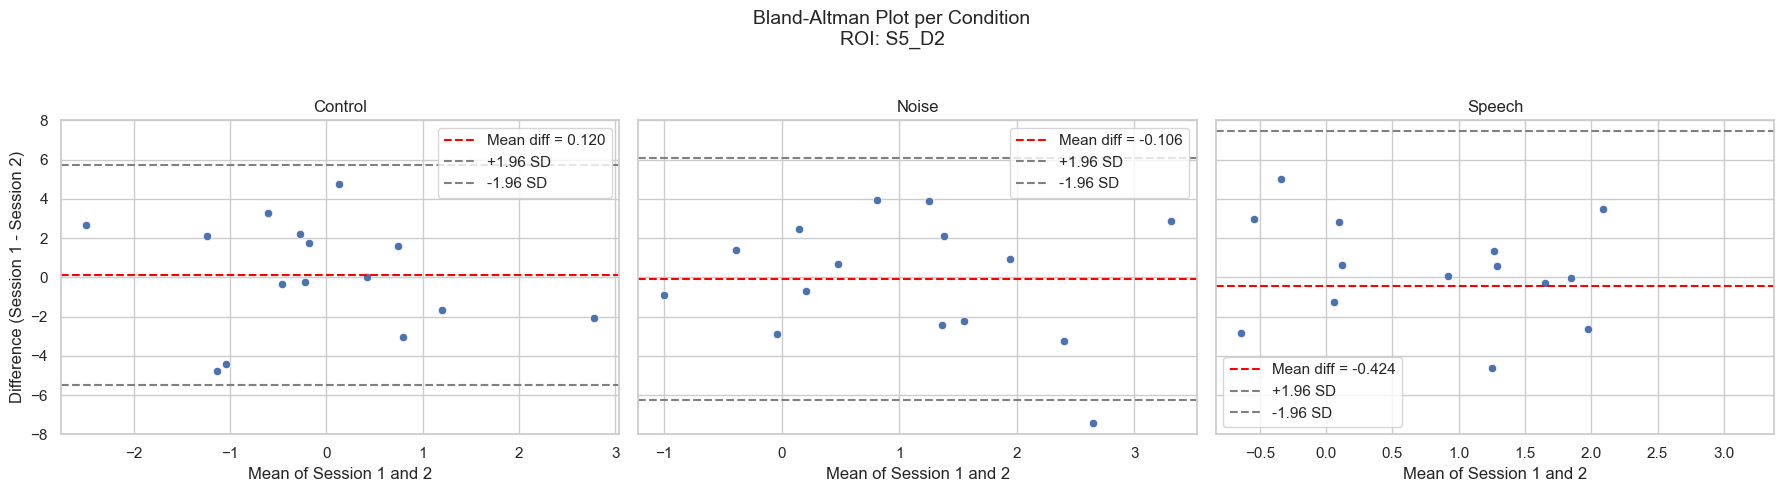

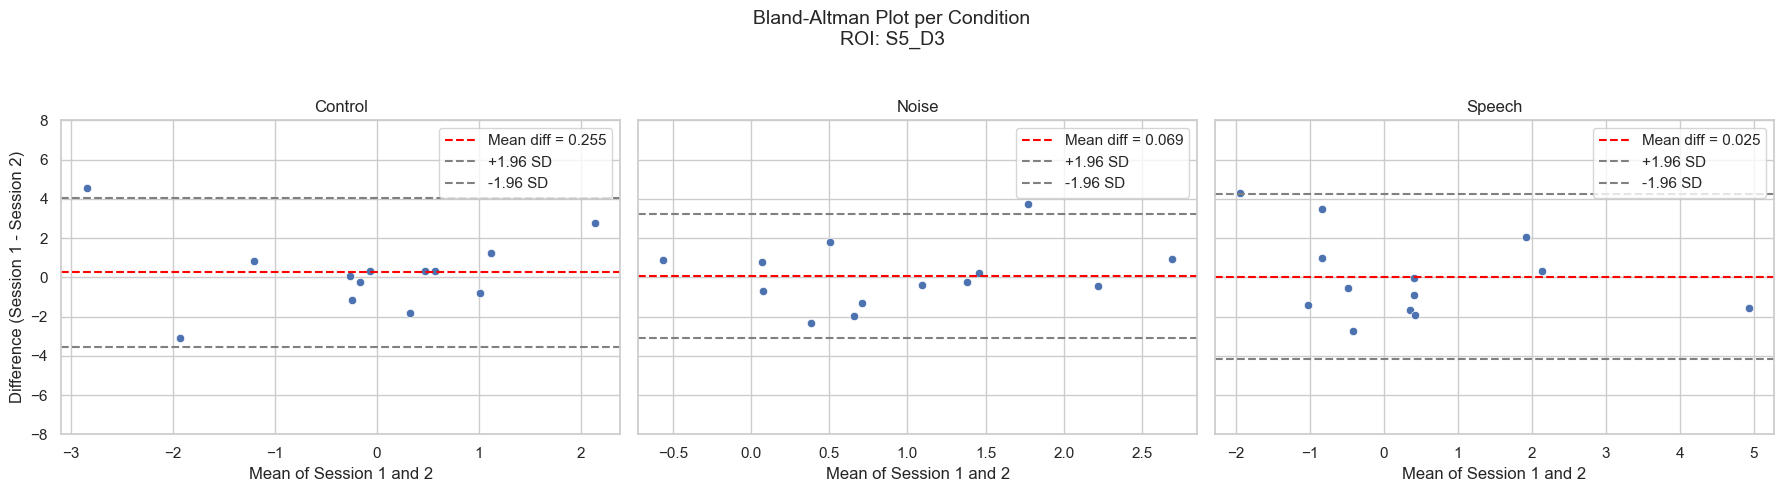

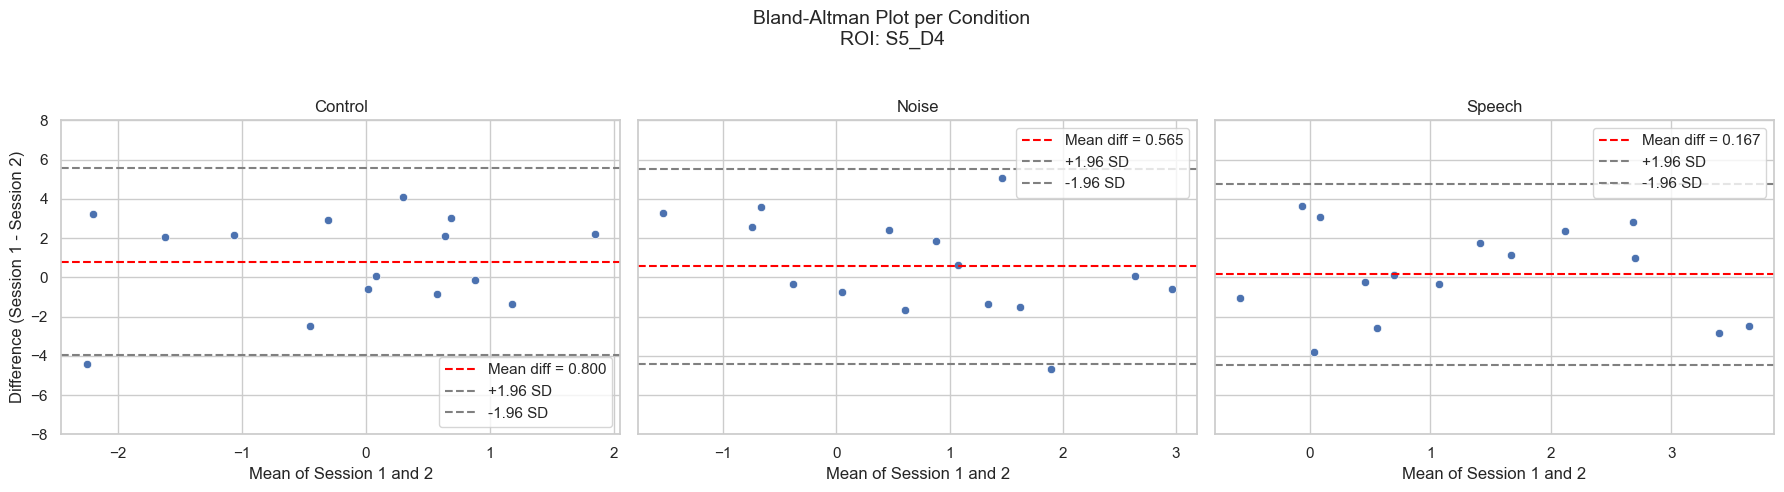

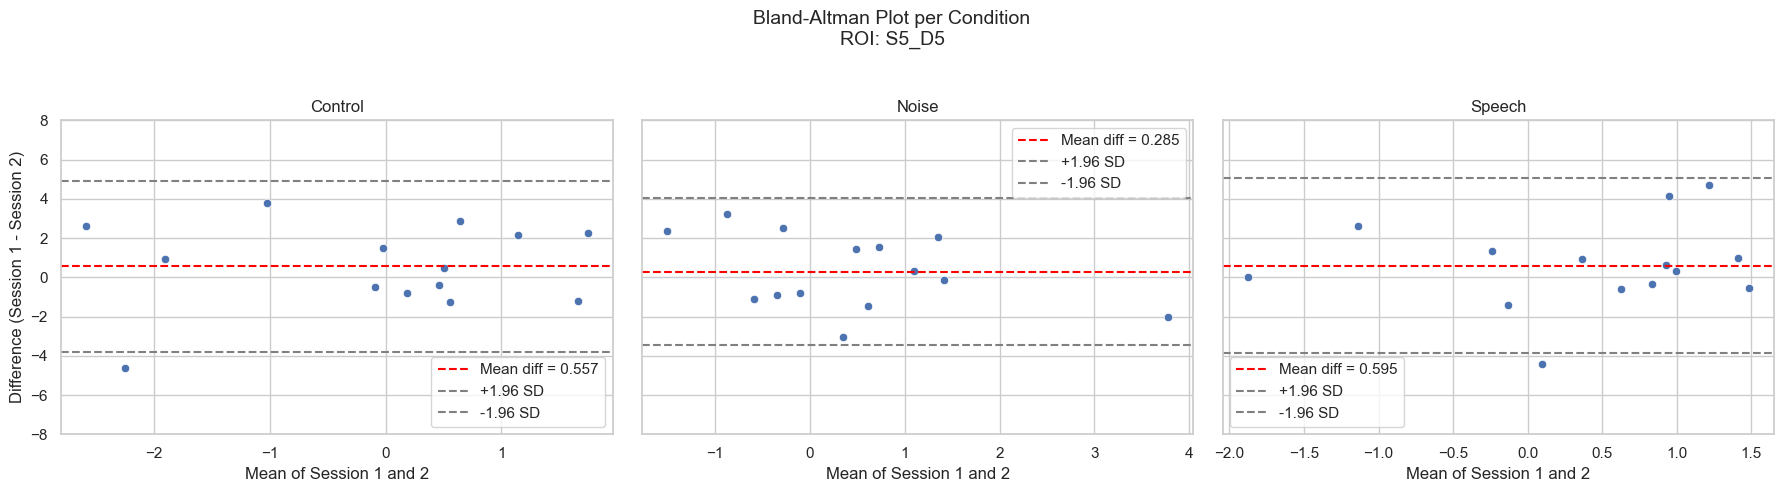

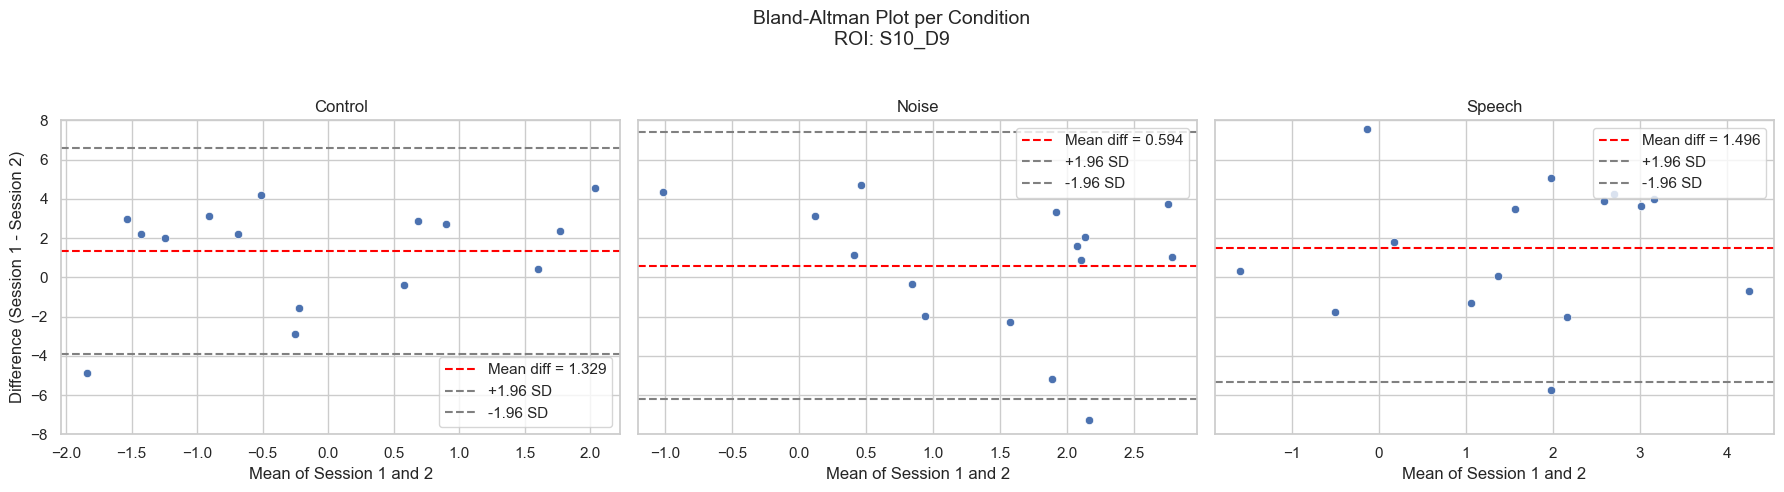

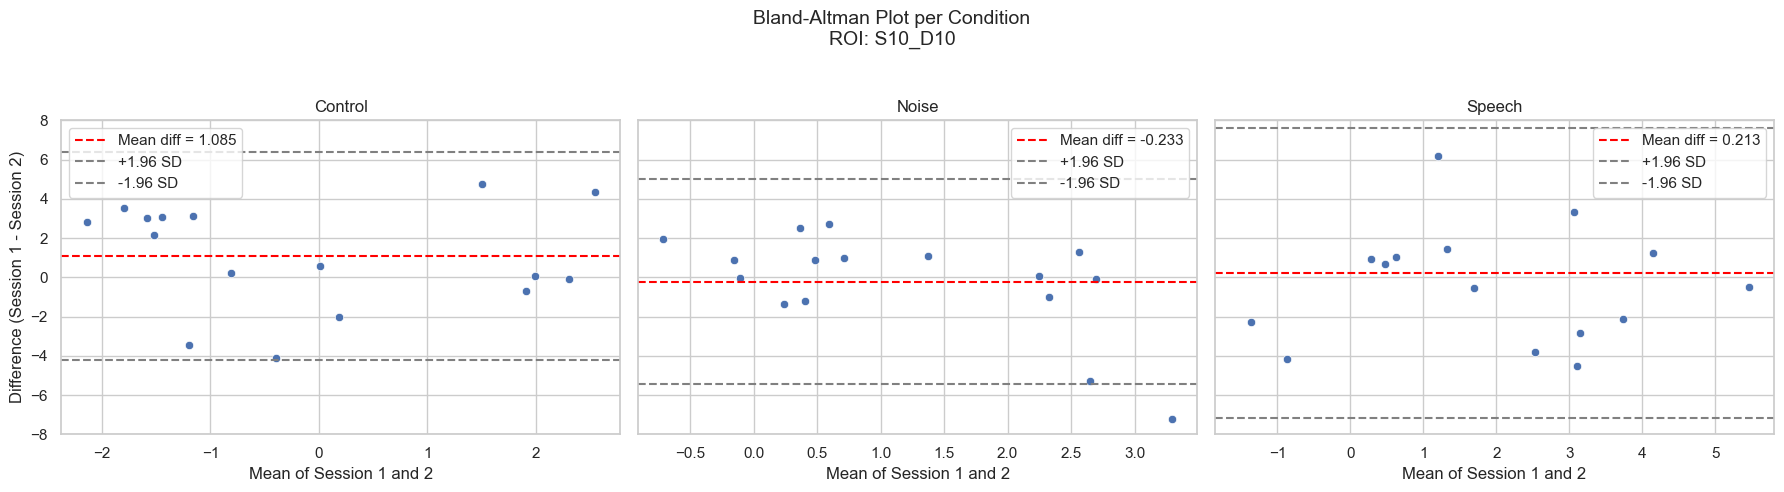

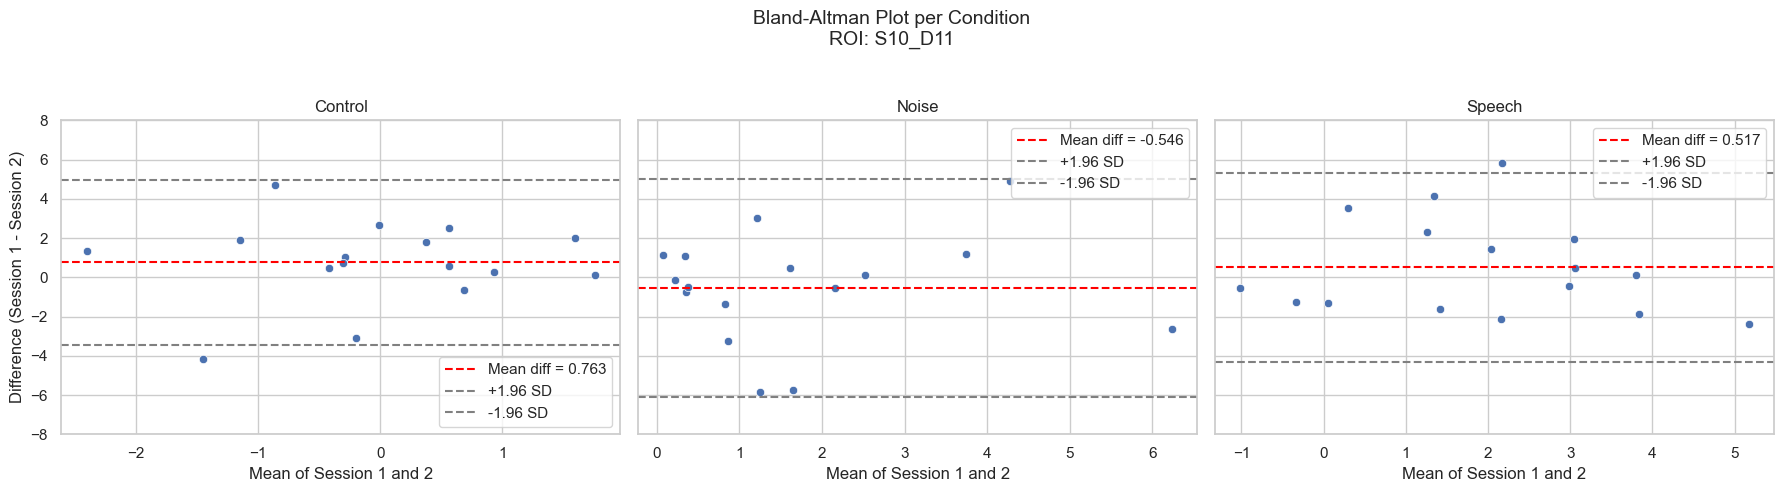

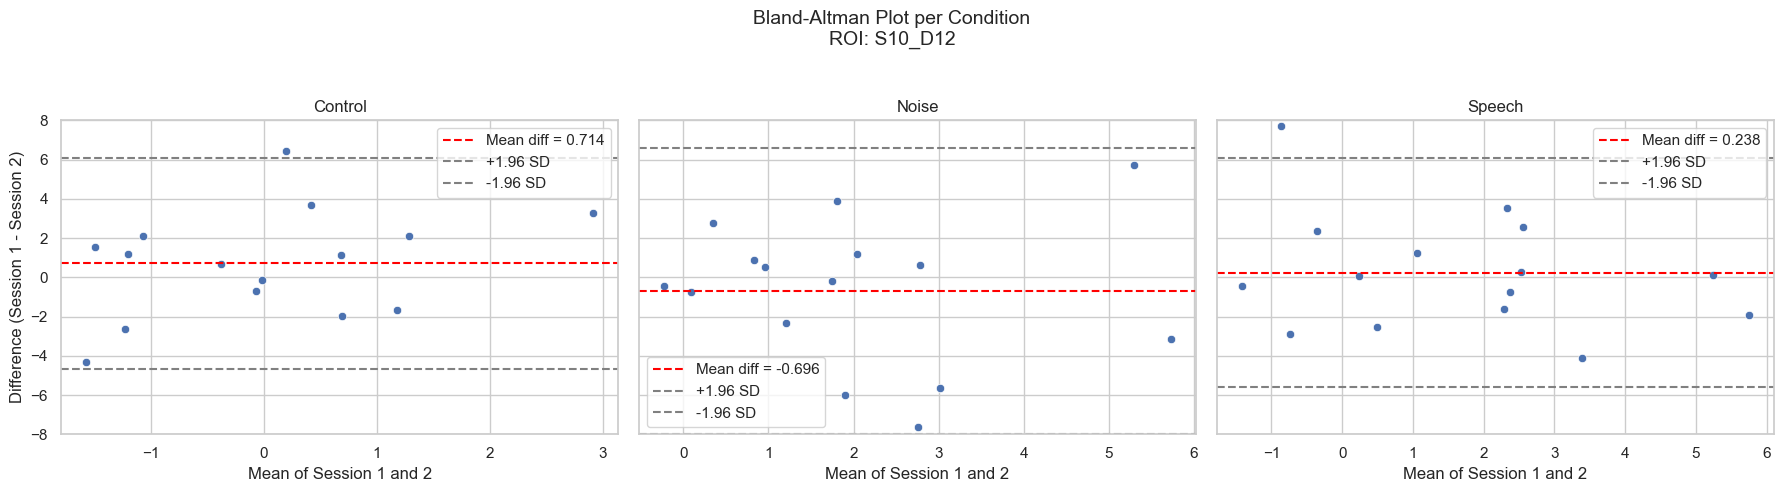

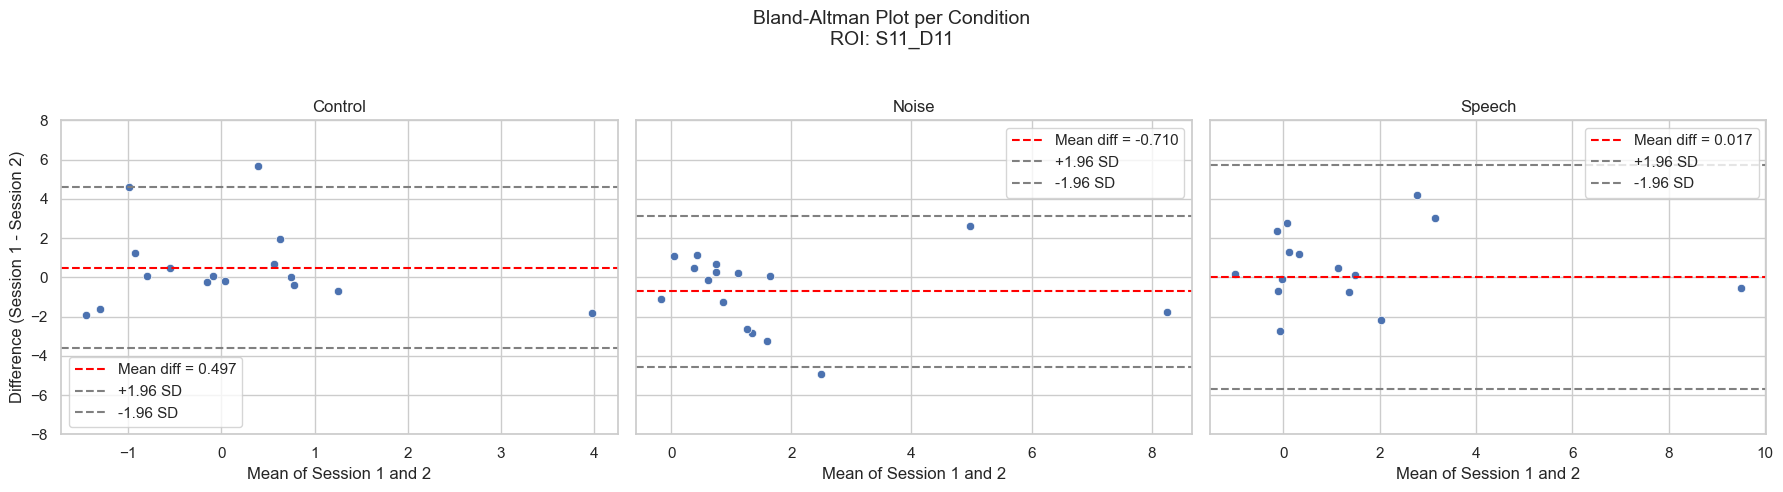

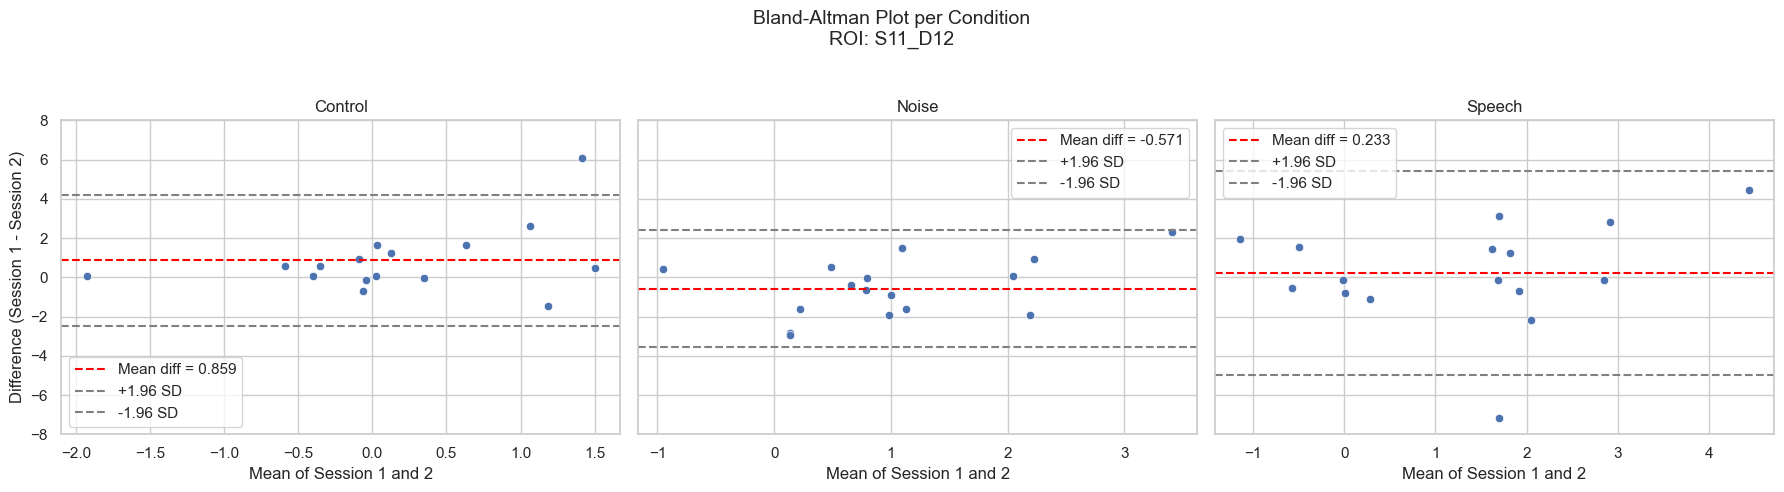

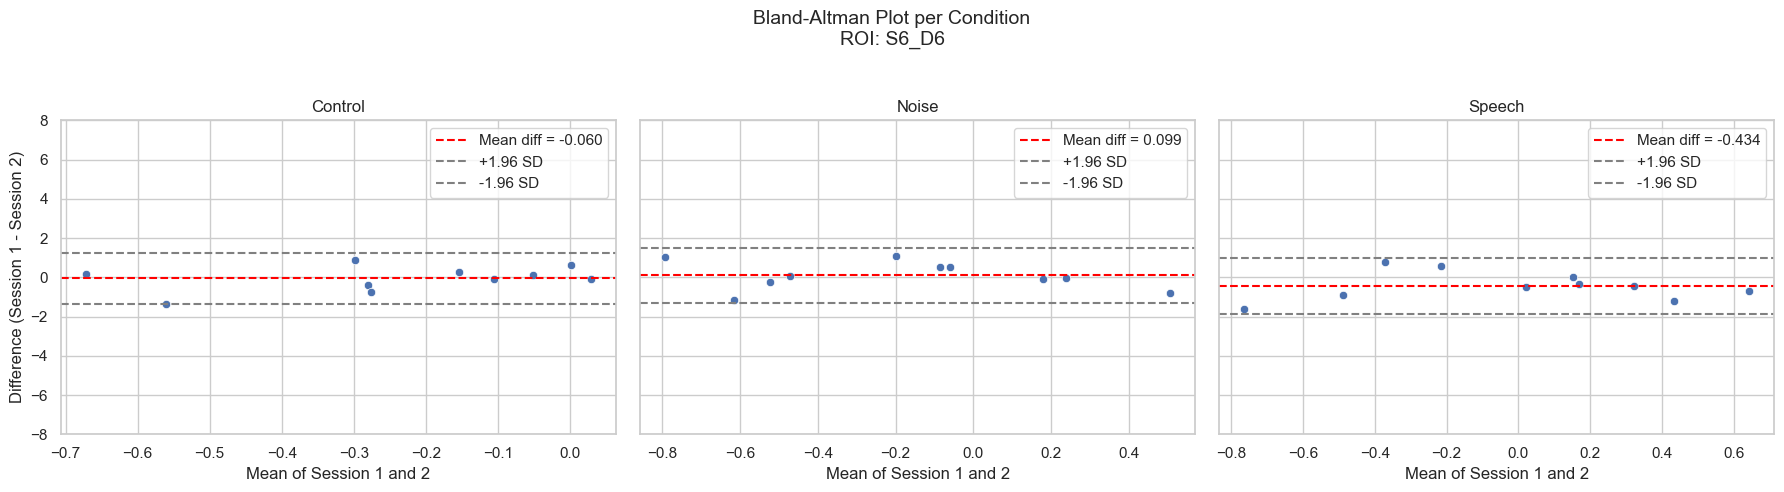

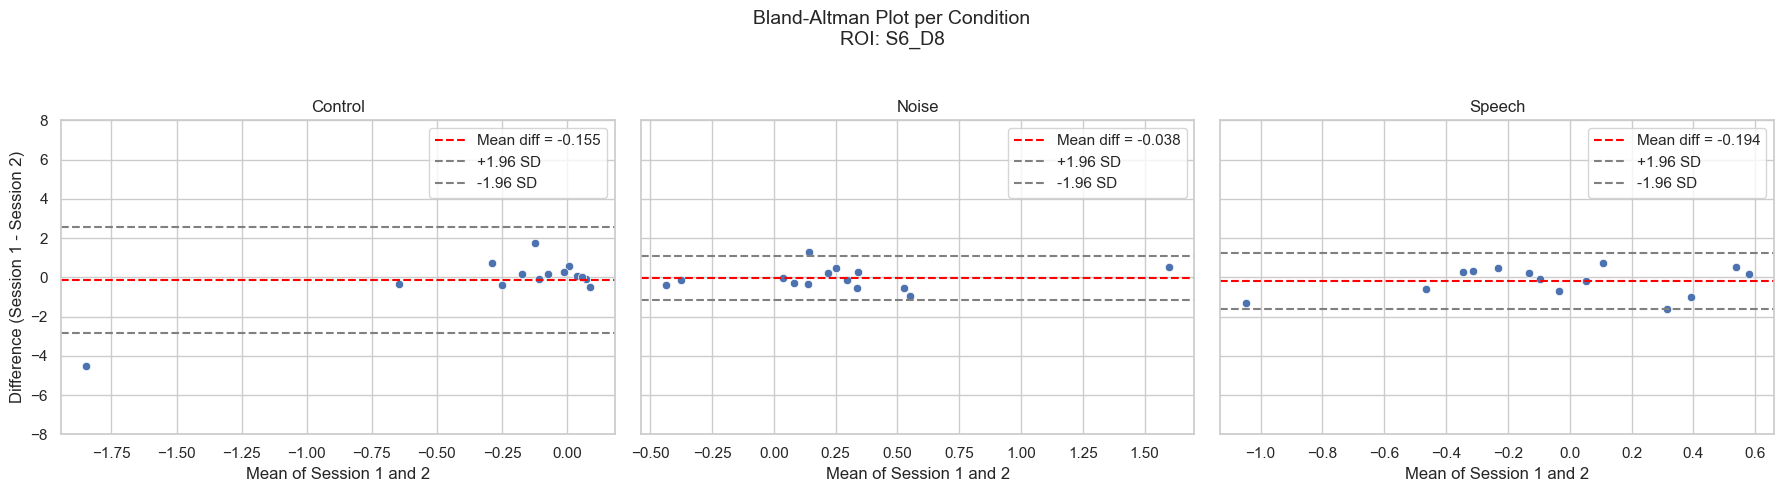

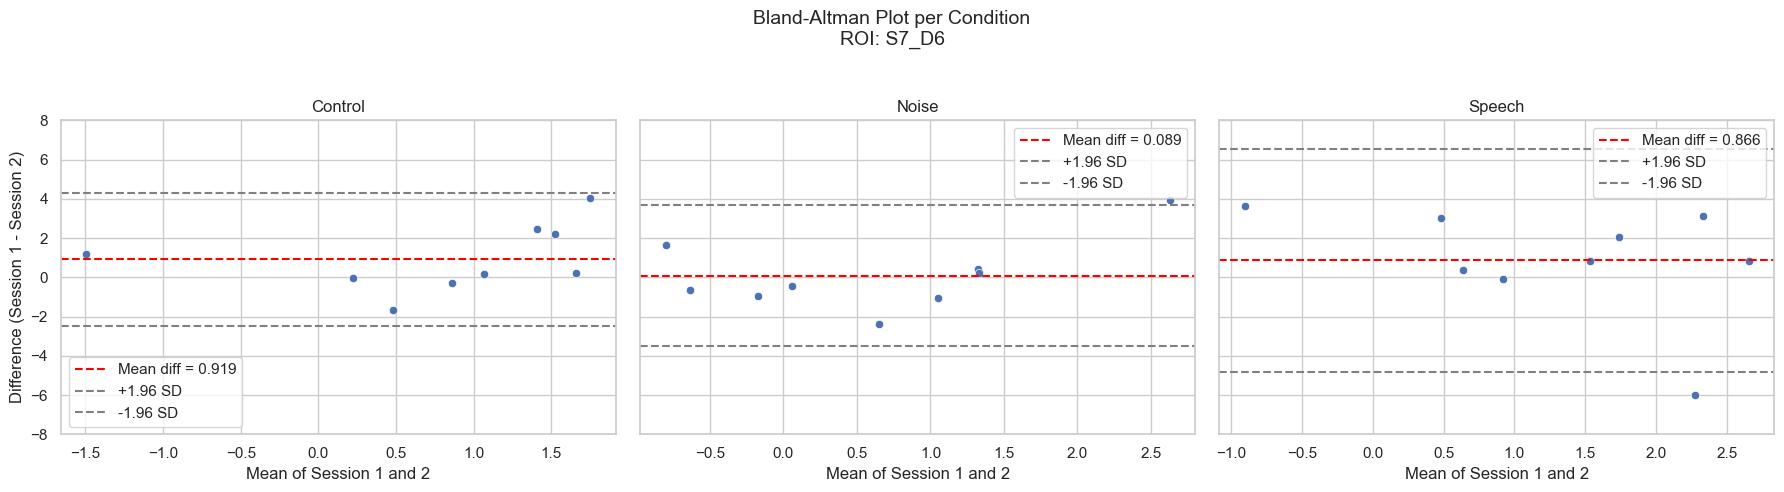

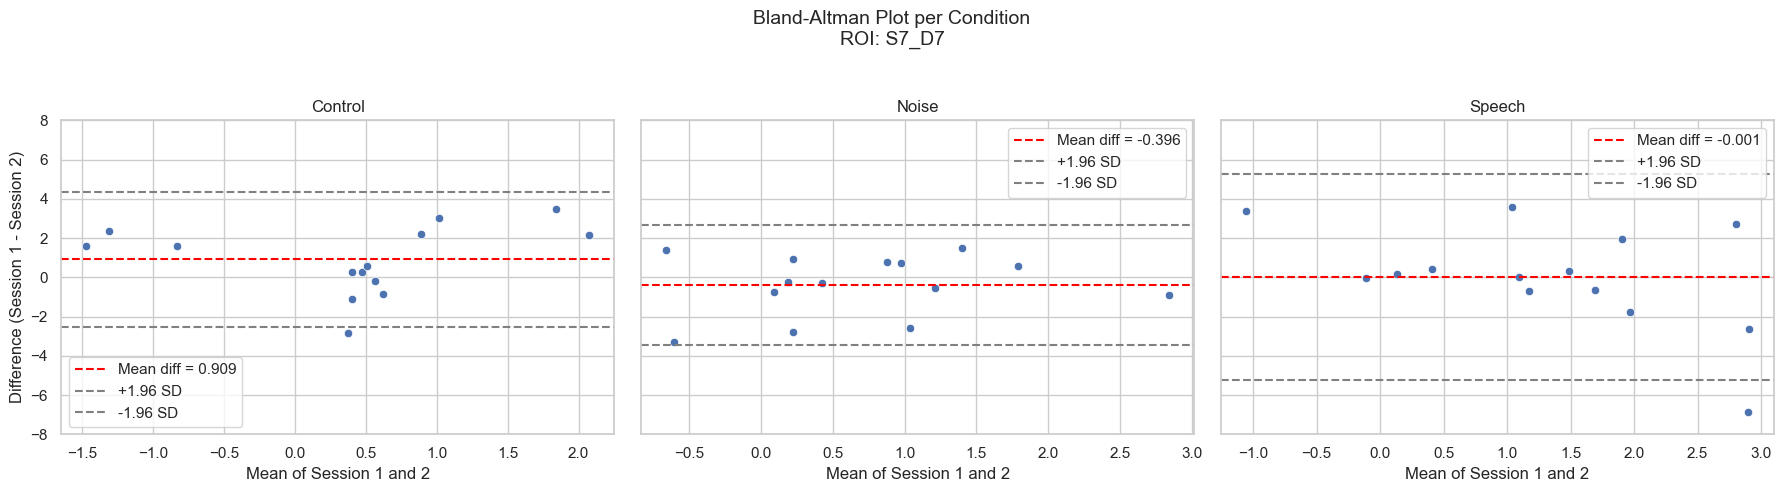

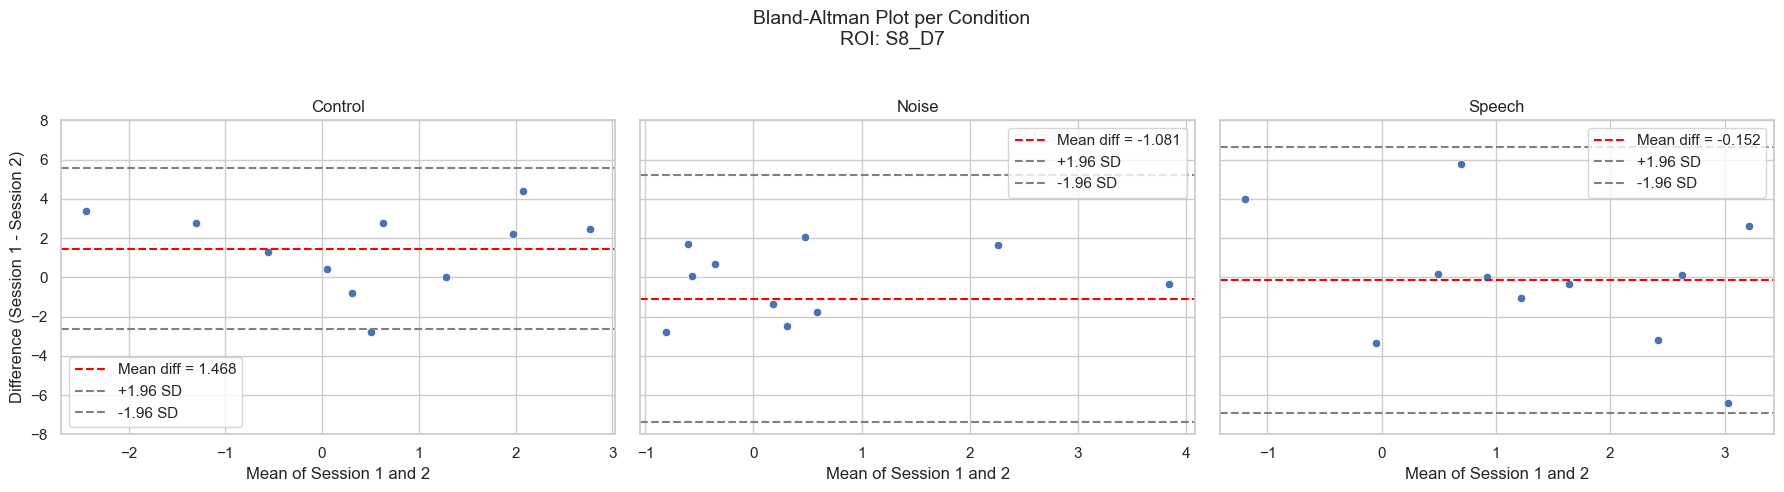

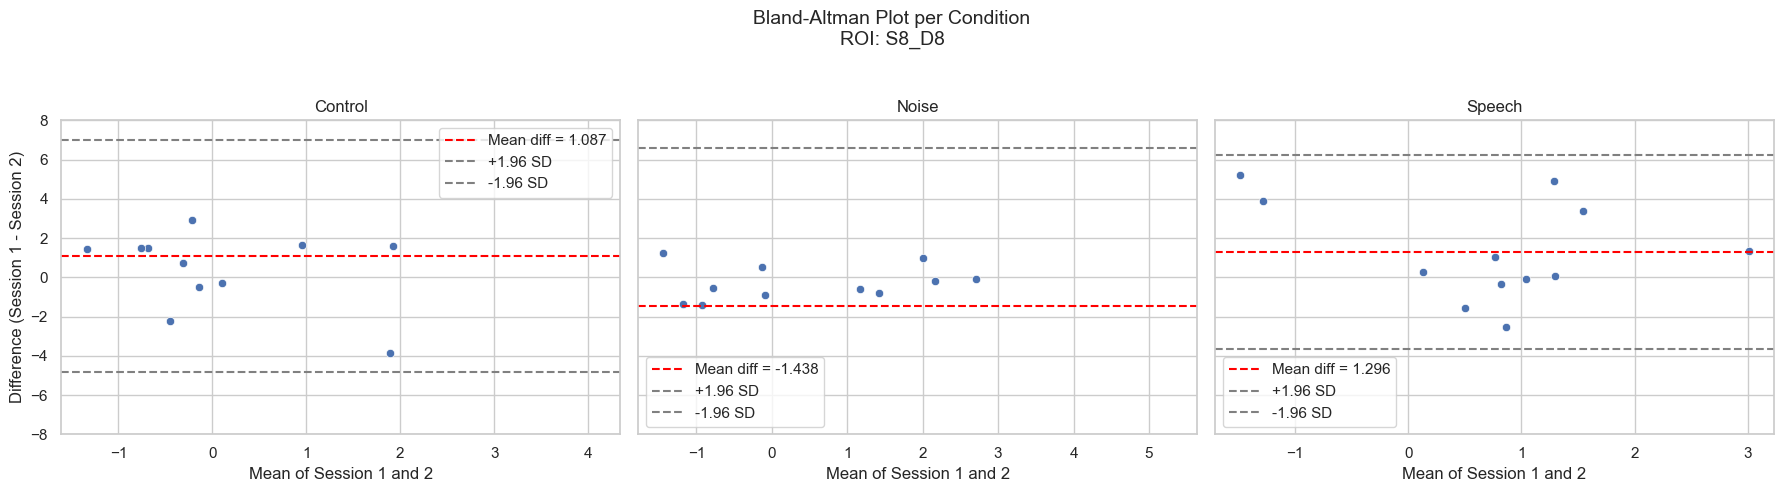

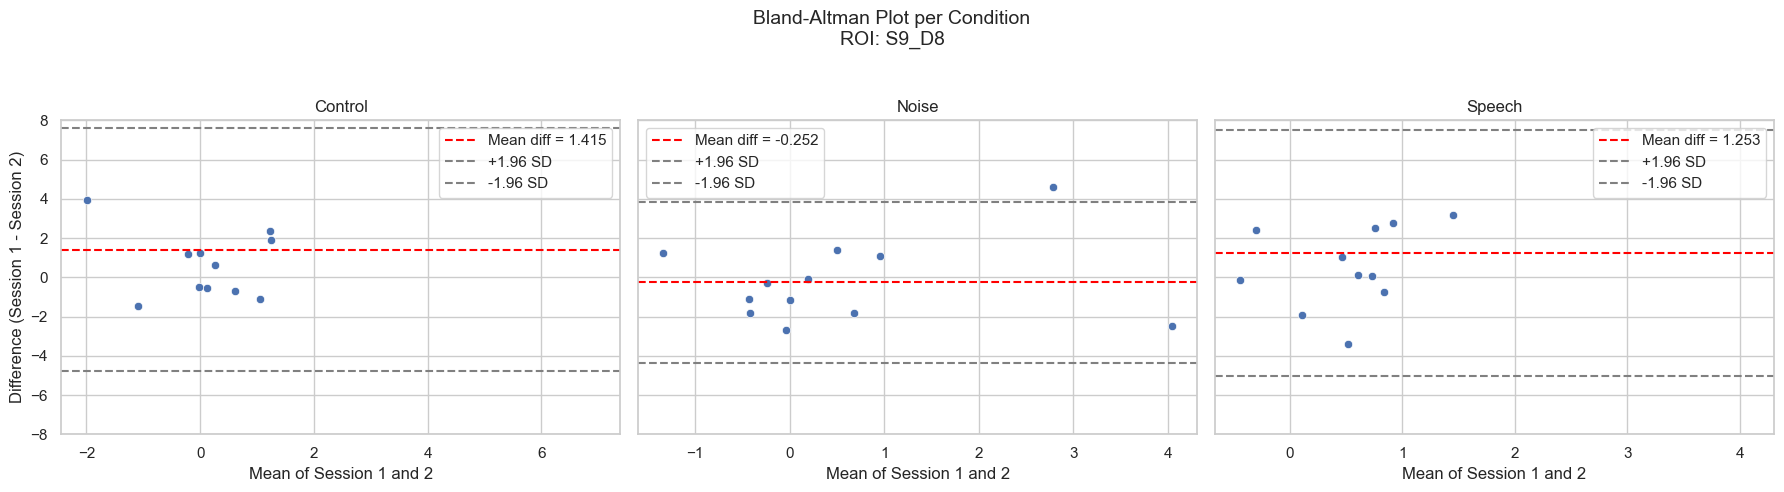

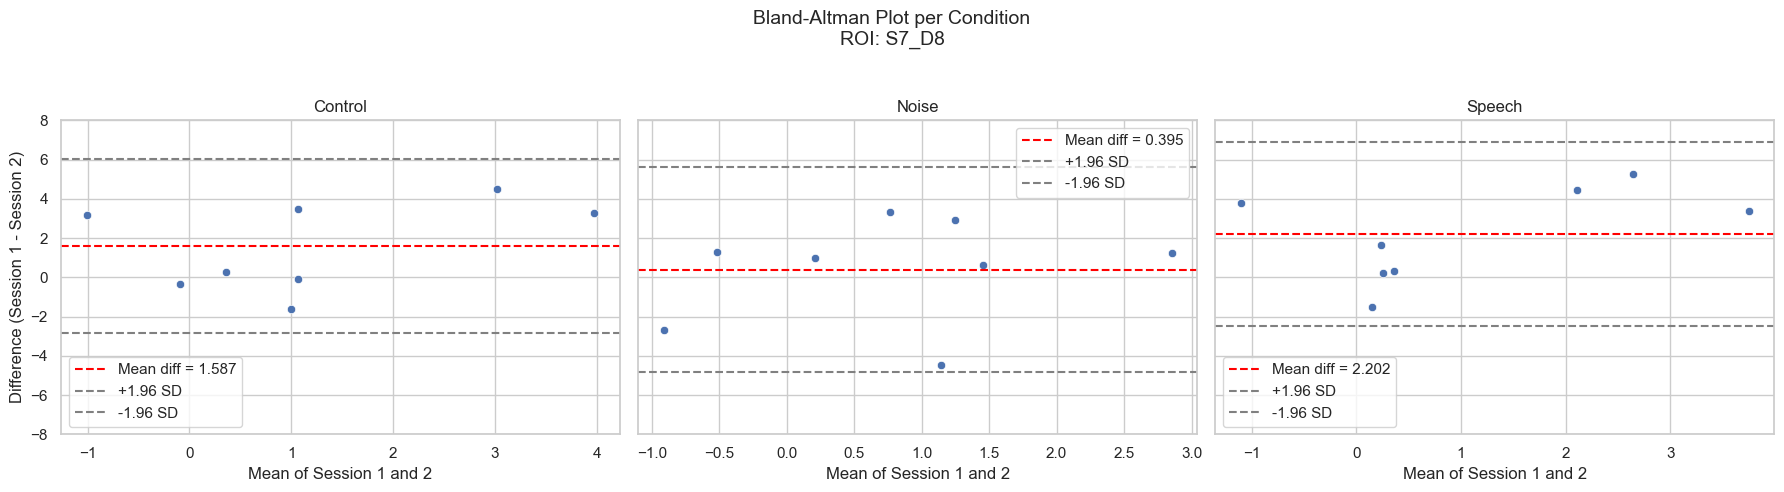

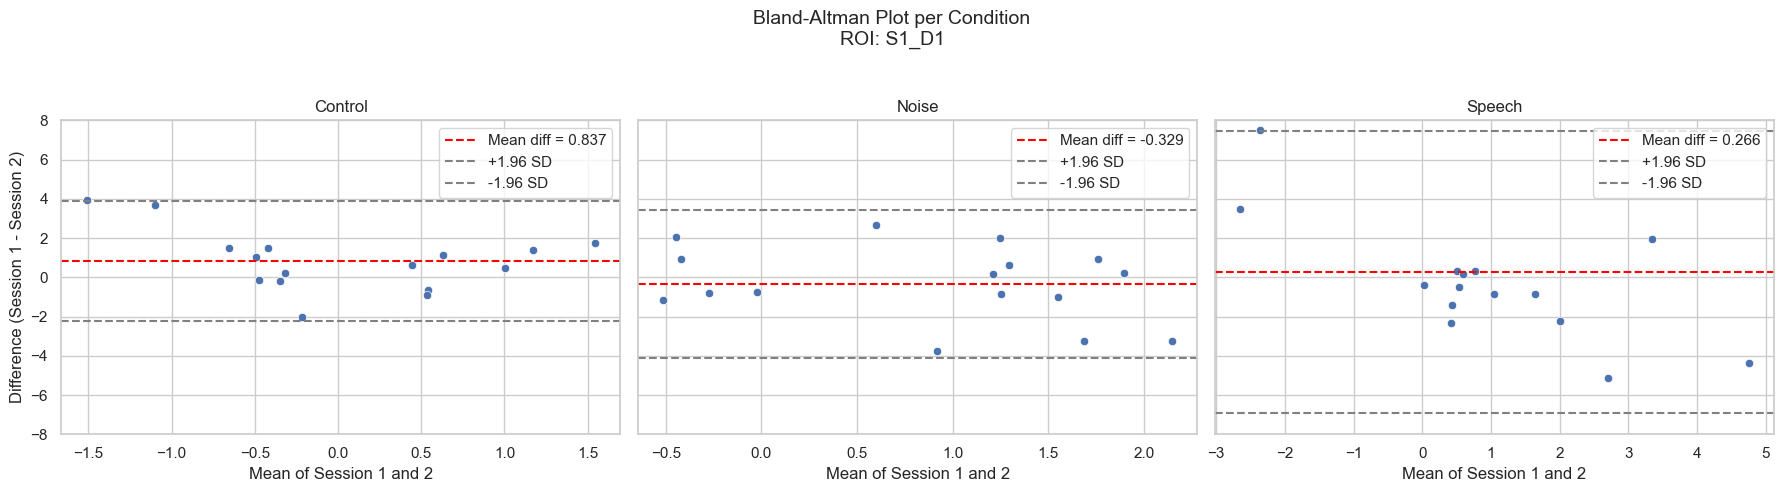

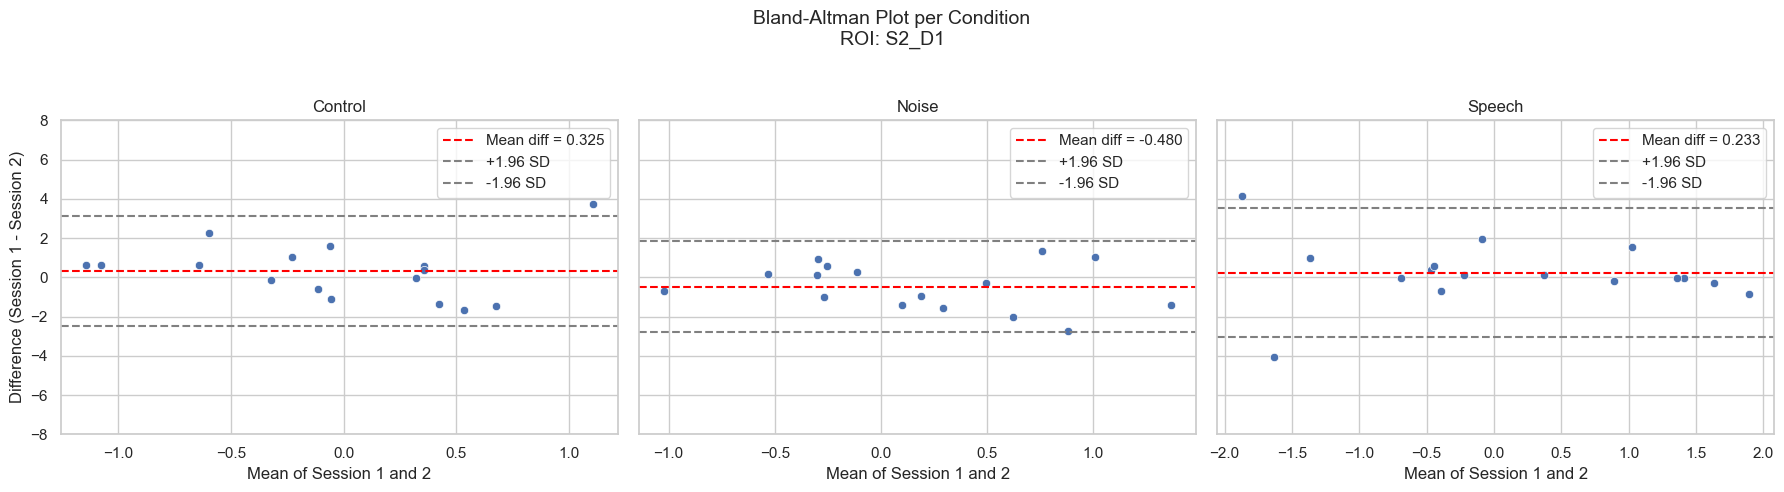

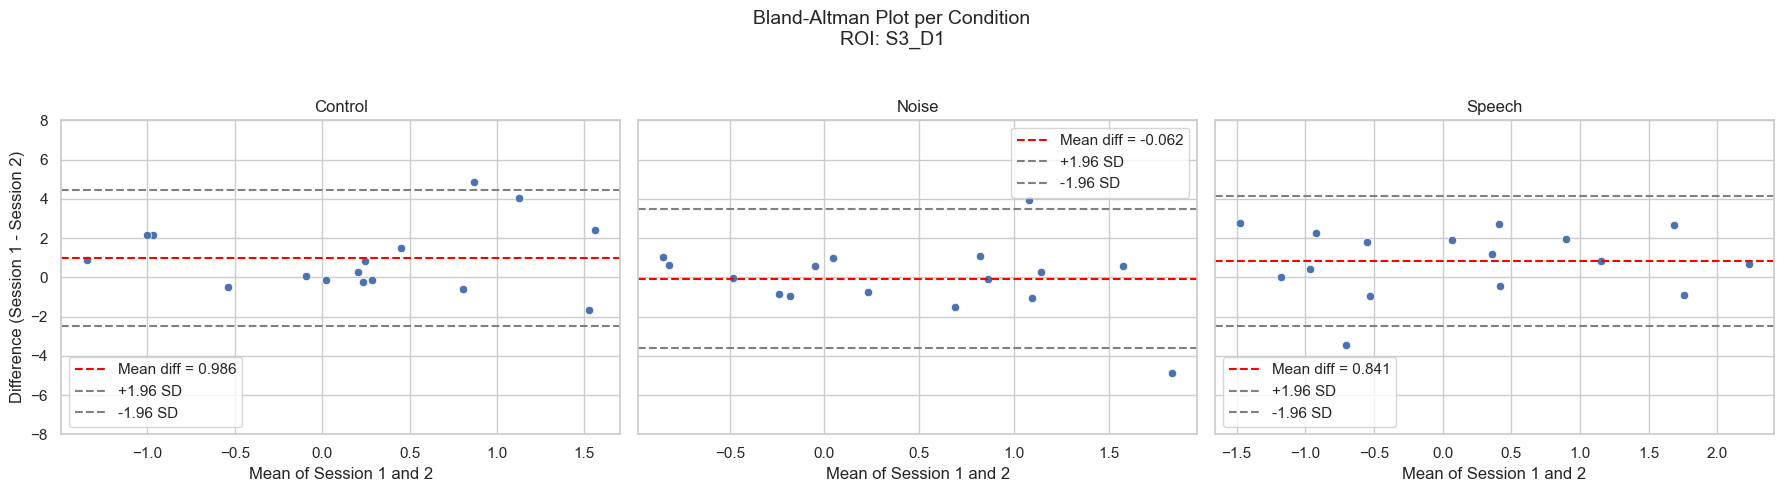

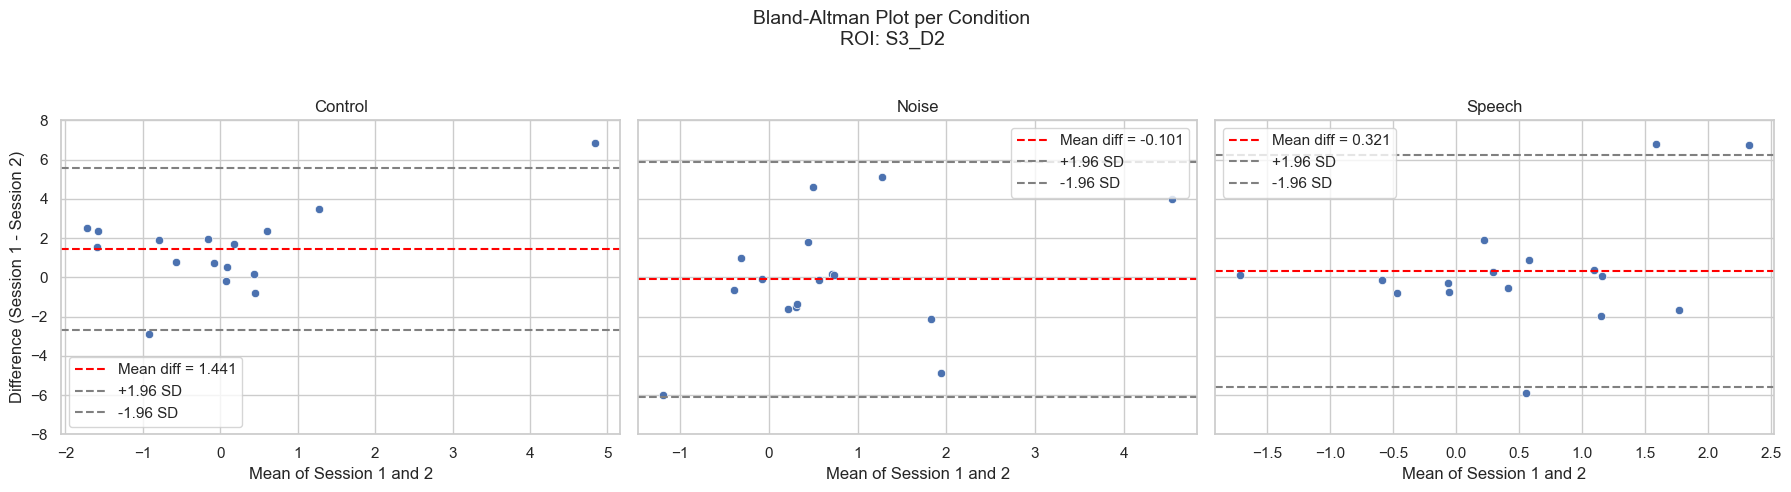

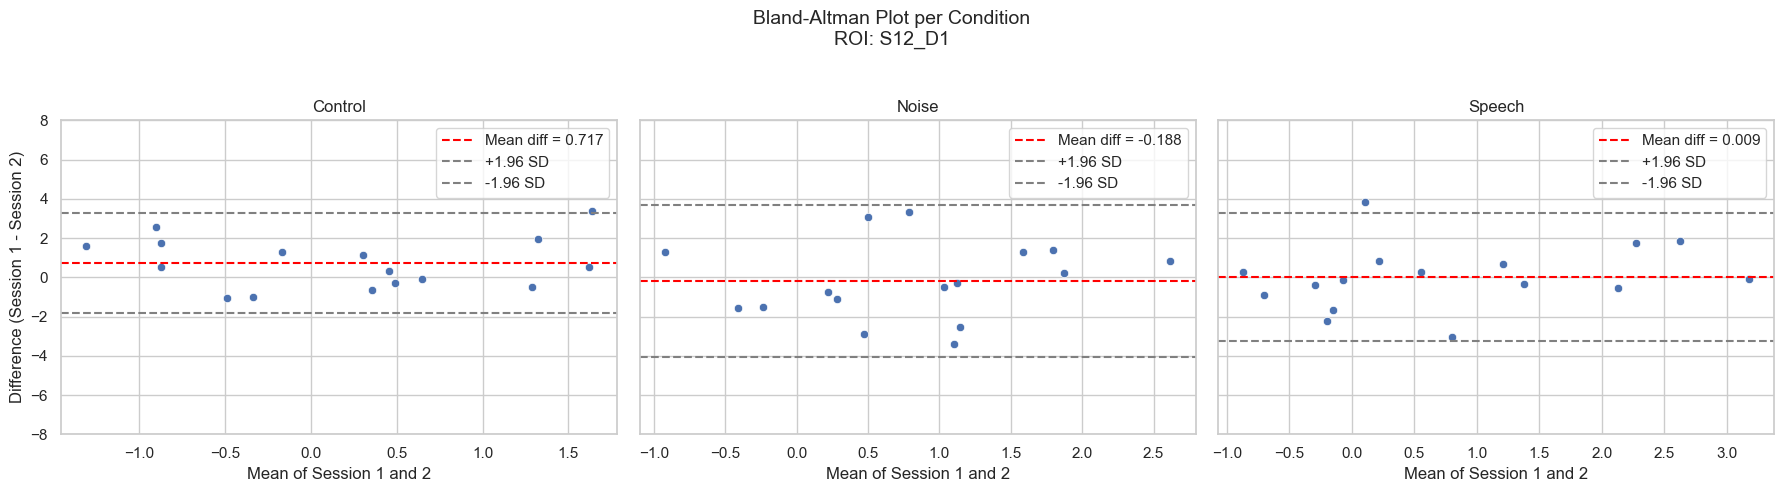

In [48]:
# Get unique experimental conditions
conditions = df_combined["Condition"].unique()
df_combined["Session"] = df_combined["Session"].astype(str).str.zfill(2)

# --- Bland-Altman plots per ROI and condition ---
for roi_name, optodes in rois.items():
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5), sharey=True)
    if len(conditions) == 1:
        axes = [axes]  # Ensure iterable if only one condition

    for ax, condition in zip(axes, conditions):
        # Filter data for current ROI and condition
        subset = df_combined[
            (df_combined["Optode"].isin(optodes)) & 
            (df_combined["Condition"] == condition)
        ]

        # Average over optodes for each subject and session
        mean_vals = subset.groupby(["Subject", "Session"])["Value"].mean().reset_index()

        # Pivot so each subject has session 01 and 02 as columns
        pivot = mean_vals.pivot(index="Subject", columns="Session", values="Value").dropna()

        if pivot.shape[0] < 2:
            ax.set_title(f'{condition}\nNot enough data')
            ax.axis('off')
            continue

        # Bland-Altman calculations
        session1 = pivot["01"]
        session2 = pivot["02"]
        avg = (session1 + session2) / 2
        diff = session1 - session2
        mean_diff = diff.mean()
        std_diff = diff.std()

        # Plot
        sns.scatterplot(x=avg, y=diff, ax=ax)
        ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.3f}')
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
        ax.set_title(f'{condition}')
        ax.set_xlabel('Mean of Session 1 and 2')
        if ax == axes[0]:
            ax.set_ylabel('Difference (Session 1 - Session 2)')
            ax.set_ylim(-8, 8)
        else:
            ax.set_ylabel('')
        ax.legend()

    plt.suptitle(f'Bland-Altman Plot per Condition\nROI: {roi_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
